# Imports


In [0]:
import os
import numpy as np
from keras.utils import np_utils
from tensorflow.python.keras.utils.data_utils import Sequence
from keras.models import Sequential,Model
from keras.layers import Dense, Reshape, Input,Dropout
from keras.layers import Dropout
from keras.layers import Flatten,Activation,concatenate,BatchNormalization
from keras.layers.convolutional import Conv2D,MaxPooling2D,Conv2DTranspose
from sklearn.model_selection import train_test_split
import keras
from PIL import Image
import tensorflow as tf
from keras import backend as K
import cv2
import pandas as pd

import matplotlib.pyplot as plt

Using TensorFlow backend.


# Download and decode data

In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
project_id='airy-cycle-248216'
bucket_name='energy_meters_dataset'

In [0]:
!gcloud config set project {project_id}

Updated property [core/project].


In [0]:
!gsutil ls gs://energy_meters_dataset/

gs://energy_meters_dataset/ENERGY_METERS_009_SEGM_ANNOTATIONS.zip
gs://energy_meters_dataset/ENERGY_METERS_009_SEGM_IMAGES_AND_MASKS.zip
gs://energy_meters_dataset/ENERGY_METERS_010_SEGM_IMAGES_ANN_MASKS.zip
gs://energy_meters_dataset/KOROSTELEV_ANNOTATIONS_07_12_19-20191207T074808Z-001.zip
gs://energy_meters_dataset/NewDataset_energy_meters.zip
gs://energy_meters_dataset/dataset_for_dcgan_energy_meter_field.zip
gs://energy_meters_dataset/dataset_for_dcgan_energy_meter_field_annotations.csv
gs://energy_meters_dataset/dataset_v_08_19_11_19_with_annotations.zip
gs://energy_meters_dataset/new_dataset_energy_meters_rf0_7.zip
gs://energy_meters_dataset/via_region_data.csv
gs://energy_meters_dataset/via_region_data.json
gs://energy_meters_dataset/OCR Model/
gs://energy_meters_dataset/Romakhin Alexander/
gs://energy_meters_dataset/Sergeev Kirill/
gs://energy_meters_dataset/seg_models_android/
gs://energy_meters_dataset/Исько Илья/


In [0]:
!gsutil cp -r gs://energy_meters_dataset/NewDataset_energy_meters.zip ./

Copying gs://energy_meters_dataset/NewDataset_energy_meters.zip...
- [1 files][ 1004 MiB/ 1004 MiB]   57.2 MiB/s                                   
Operation completed over 1 objects/1004.1 MiB.                                   


In [0]:
!unzip -qq /content/NewDataset_energy_meters.zip

NewDataset_energy_meters/barcode/DSC_лічильник-1-1024x685.jpg/:  mismatching "local" filename (NewDataset_energy_meters/barcode/DSC_╨╗╤Ц╤З╨╕╨╗╤М╨╜╨╕╨║-1-1024x685.jpg/),
         continuing with "central" filename version
NewDataset_energy_meters/barcode/DSC_лічильник-1-1024x685.jpg/1580187221_mmoiseev.json.jpg:  mismatching "local" filename (NewDataset_energy_meters/barcode/DSC_╨╗╤Ц╤З╨╕╨╗╤М╨╜╨╕╨║-1-1024x685.jpg/1580187221_mmoiseev.json.jpg),
         continuing with "central" filename version
NewDataset_energy_meters/barcode/DSC_лічильник-1-1024x685.jpg/1580189680_mmoiseev.json.jpg:  mismatching "local" filename (NewDataset_energy_meters/barcode/DSC_╨╗╤Ц╤З╨╕╨╗╤М╨╜╨╕╨║-1-1024x685.jpg/1580189680_mmoiseev.json.jpg),
         continuing with "central" filename version
NewDataset_energy_meters/data/annotations/segmentation/DSC_лічильник-1-1024x685.jpg/:  mismatching "local" filename (NewDataset_energy_meters/data/annotations/segmentation/DSC_╨╗╤Ц╤З╨╕╨╗╤М╨╜╨╕╨║-1-1024x685.jpg/),
         con

In [0]:
import os
DATA_DIR='/content/NewDataset_energy_meters'
SEG_DIR='/content/segmentations/'
READ_DIR='/content/read_area/'
SERIAL_DIR='/content/serial_area/'
SEG_SHAPE=None#(512,512)
READ_SHAPE=None#(64,512)
SERIAL_SHAPE=None#(64,512)
os.listdir(DATA_DIR)

['serial_number',
 'data',
 'masks',
 'barcode',
 'serial_number_vertical',
 'reading']

In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [0]:
DATA_DIR+'/masks/332.jpg'

'/content/NewDataset_energy_meters/masks/332.jpg'

In [0]:
im=cv2.imread(DATA_DIR+'/masks/332.jpg')

In [0]:
df=pd.read_csv(DATA_DIR+'/data/datasets/dataset_v12.csv')

In [0]:
df

,image,annotation
0,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
1,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
2,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
3,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
4,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
...,...,...
1674,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
1675,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
1676,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...
1677,/home/ds/Projects/REGINA/data/original_images/...,/home/ds/Projects/REGINA/data/annotations/segm...


In [0]:
def repath(x):
  return x.split('REGINA')[1]
def repath_df(df):
  return df.apply(repath)
df['image']=repath_df(df['image'])
df['annotation']=repath_df(df['annotation'])

In [0]:
import json
def decode_annot(x):
  fname=DATA_DIR+x
  #print(fname)
  fdata=open(fname,'r').read()
  jdata=json.loads(fdata)
  return jdata
def decode_df(df):
  return df.apply(decode_annot)
df['jdata']=decode_df(df['annotation'])

In [0]:
def rect2poly(rect):
  all_x=[]
  all_y=[]
  all_x.append(rect['x'])
  all_y.append(rect['y'])
  all_x.append(rect['x']+rect['width'])
  all_y.append(rect['y'])
  all_x.append(rect['x']+rect['width'])
  all_y.append(rect['y']+rect['height'])
  all_x.append(rect['x'])
  all_y.append(rect['y']+rect['height'])
  return all_x,all_y
def decode_jdata(x):
  #print(x)
  res_data={
      'serial_x':None,
      'serial_y':None,
      'reader_x':None,
      'reader_y':None,
  }
  regions=x['jdata']['regions']
  for r in regions:
    #print(r['region_attributes'])
    if('mask_type' in r['region_attributes'] and 'value' in r['region_attributes']):
      if('polygon' in r['shape_attributes']['name']):
        
        if('serial' in r['region_attributes']['mask_type']):
          #print(r['region_attributes']['value'])
          x['value_s']=r['region_attributes']['value']
          #print(r['shape_attributes'])
          x['serial_x']=r['shape_attributes']['all_points_x']
          x['serial_y']=r['shape_attributes']['all_points_y']
        if('reading' in r['region_attributes']['mask_type']):
          x['value_r']=r['region_attributes']['value']
          #print(r['region_attributes']['mask_type'])
          x['reader_x']=r['shape_attributes']['all_points_x']
          x['reader_y']=r['shape_attributes']['all_points_y']
      if('rect' in r['shape_attributes']['name']):
        if('serial' in r['region_attributes']['mask_type']):
          x['value_s']=r['region_attributes']['value']
          x['serial_x'],x['serial_y']=rect2poly(r['shape_attributes'])
        if('reader' in r['region_attributes']['mask_type']):
          x['value_r']=r['region_attributes']['value']
          x['reader_x'],x['reader_y']=rect2poly(r['shape_attributes'])
  return x
def decode_jdata_df(df):
  return df.apply(lambda x:decode_jdata(x), axis=1)  
res=decode_jdata_df(df)
res=res[res['value_s'].notnull()]
res=res[res['value_r'].notnull()]
res['value_s']=res['value_s'].map(lambda row:row.split("№")[-1])
res['value_s']=res['value_s'].map(lambda row:row.replace("-",""))
res['value_r']=res['value_r'].map(lambda row:row.replace(".",""))
res['value_r']=res['value_r'].map(lambda row:row.replace(",",""))
res['data_index']=res['value_r'].index.to_list()

In [0]:
res

,annotation,image,jdata,reader_x,reader_y,serial_x,serial_y,value_r,value_s,data_index
0,/data/annotations/segmentation/good (338).jpg/...,/data/original_images/good (338).jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[175, 342, 341, 174]","[190, 187, 207, 209]","[320, 399, 400, 320]","[316, 313, 325, 328]",002229,211330,0
1,/data/annotations/segmentation/1655.jpg/157975...,/data/original_images/1655.jpg,"{'filename': '1655.jpg', 'size': 100682, 'regi...","[179, 348, 349, 180]","[234, 232, 261, 262]","[289, 389, 389, 289]","[427, 427, 444, 444]",000011,08478375,1
2,/data/annotations/segmentation/box_268_020.jpg...,/data/original_images/box_268_020.jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[169, 1004, 995, 161]","[400, 430, 595, 572]","[672, 1206, 1206, 672]","[807, 811, 872, 869]",0000797,305224,2
3,/data/annotations/segmentation/1450802582_Schi...,/data/original_images/1450802582_Schietchik-el...,"{'size': -1, 'regions': [{'shape_attributes': ...","[133, 133, 444, 447]","[141, 199, 199, 136]","[65, 67, 230, 229]","[372, 400, 394, 370]",00000298,60871420,3
4,/data/annotations/segmentation/IMG_20191117_15...,/data/original_images/IMG_20191117_152218.jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[1690, 2521, 2537, 1691]","[1965, 1947, 2110, 2120]","[2759, 3237, 3237, 2761]","[2091, 2093, 2153, 2147]",563184,0524568809,4
...,...,...,...,...,...,...,...,...,...,...
1674,/data/annotations/segmentation/1546.jpg/157975...,/data/original_images/1546.jpg,"{'filename': '1546.jpg', 'size': 1645543, 'reg...","[189, 193, 1059, 1055]","[720, 848, 808, 667]","[445, 444, 737, 737]","[1120, 1174, 1161, 1110]",000024,39728598,1674
1675,/data/annotations/segmentation/1604.jpg/157975...,/data/original_images/1604.jpg,"{'filename': '1604.jpg', 'size': 35848, 'regio...","[26, 22, 188, 187]","[152, 179, 186, 160]","[72, 72, 130, 130]","[225, 235, 236, 226]",000024,36478200,1675
1676,/data/annotations/segmentation/good (203).jpg/...,/data/original_images/good (203).jpg,"{'filename': 'good (203).jpg', 'size': 64708, ...","[89, 209, 209, 88]","[237, 238, 279, 276]","[123, 238, 239, 124]","[374, 374, 388, 387]",37551,0854390,1676
1677,/data/annotations/segmentation/good (181).jpg/...,/data/original_images/good (181).jpg,"{'filename': 'good (181).jpg', 'size': 335319,...","[187, 735, 735, 186]","[287, 308, 399, 387]","[739, 975, 975, 740]","[605, 607, 632, 630]",002914,011067091180652,1677


In [0]:
def get_mask(im,x):
  mask=np.zeros(im.shape)
  pts=np.array((x['reader_x'],x['reader_y']))
  pts=np.moveaxis(pts,0,-1)
  #print(pts.shape)
  cv2.fillPoly(mask,np.int32([pts]),(1,0,0))
  pts=np.array((x['serial_x'],x['serial_y']))
  pts=np.moveaxis(pts,0,-1)
  cv2.fillPoly(mask,np.int32([pts]),(0,1,0))
  return mask
def get_crop_by_mask(im,mask,ch=0):
  cnt,_=cv2.findContours(mask[:,:,ch].astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  rect =cv2.boundingRect(cnt[0])
  return im[int(rect[1]):int(rect[1])+int(rect[3]),int(rect[0]):int(rect[0])+int(rect[2]),:].copy()

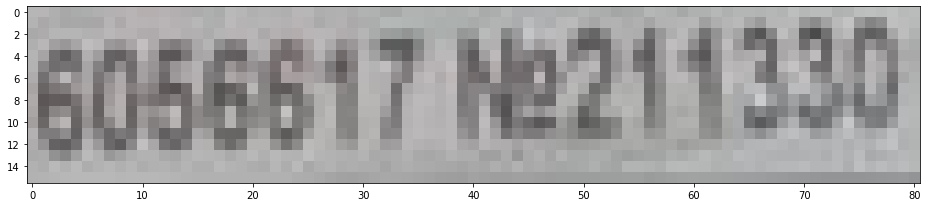

In [0]:
plt.subplots(figsize=(16,16))
im=cv2.imread(DATA_DIR+res.iloc[0]['image'])
plt.imshow(get_crop_by_mask(im,get_mask(im,res.iloc[0]),ch=1))

In [0]:
from tqdm import tqdm

In [0]:
!rm -rf {SEG_DIR}
!rm -rf {READ_DIR}
!rm -rf {SERIAL_DIR}
!mkdir {SEG_DIR}
!mkdir {READ_DIR}
!mkdir {SERIAL_DIR}
train_df=[]
for i in tqdm(range(len(res))):
  d=res.iloc[i]
  #val_s=d['value_s']
  #val_r=d['value_r']
  im=cv2.imread(DATA_DIR+d['image'])
  d['height']=im.shape[0]
  d['width']=im.shape[1]
  mask=get_mask(im,d)
  crop_r=get_crop_by_mask(im,mask,ch=0)
  crop_s=get_crop_by_mask(im,mask,ch=1)
  #print(crop_r.shape,crop_s.shape)
  ind=d['data_index']
  seg_name=f'{ind}.png'
  serial_name=f'{ind}.png'
  read_name=f'{ind}.png'
  d['is_serial_vertical']=crop_s.shape[0]>crop_s.shape[1]
  if(SEG_SHAPE):
    mask=cv2.resize(mask,SEG_SHAPE)
  if(READ_SHAPE):
    crop_r=cv2.resize(crop_r,READ_SHAPE)
  if(SERIAL_SHAPE):
    crop_s=cv2.resize(crop_s,SERIAL_SHAPE)
  cv2.imwrite(SEG_DIR+seg_name,mask)
  cv2.imwrite(READ_DIR+read_name,crop_r)
  cv2.imwrite(SERIAL_DIR+serial_name,crop_s)
  
  train_df.append(d)
train_df=pd.DataFrame(train_df)

  0%|          | 0/1358 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/l

In [0]:
train_df=pd.DataFrame(train_df)

In [0]:
train_df.to_csv('train_df.csv',index=False)

In [0]:
train_df=pd.read_csv('train_df.csv')

In [0]:
train_df['is_serial_vertical'].sum()

156

In [0]:
len(os.listdir('/content/read_area'))

1358

In [0]:
train_df=pd.read_csv('train_df.csv')

In [0]:
train_df.head()

,annotation,image,jdata,reader_x,reader_y,serial_x,serial_y,value_r,value_s,data_index,height,width,is_serial_vertical
0,/data/annotations/segmentation/good (338).jpg/...,/data/original_images/good (338).jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[175, 342, 341, 174]","[190, 187, 207, 209]","[320, 399, 400, 320]","[316, 313, 325, 328]",002229,211330,0,600,800,False
1,/data/annotations/segmentation/1655.jpg/157975...,/data/original_images/1655.jpg,"{'filename': '1655.jpg', 'size': 100682, 'regi...","[179, 348, 349, 180]","[234, 232, 261, 262]","[289, 389, 389, 289]","[427, 427, 444, 444]",000011,08478375,1,766,564,False
2,/data/annotations/segmentation/box_268_020.jpg...,/data/original_images/box_268_020.jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[169, 1004, 995, 161]","[400, 430, 595, 572]","[672, 1206, 1206, 672]","[807, 811, 872, 869]",0000797,305224,2,1229,1373,False
3,/data/annotations/segmentation/1450802582_Schi...,/data/original_images/1450802582_Schietchik-el...,"{'size': -1, 'regions': [{'shape_attributes': ...","[133, 133, 444, 447]","[141, 199, 199, 136]","[65, 67, 230, 229]","[372, 400, 394, 370]",00000298,60871420,3,441,640,False
4,/data/annotations/segmentation/IMG_20191117_15...,/data/original_images/IMG_20191117_152218.jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[1690, 2521, 2537, 1691]","[1965, 1947, 2110, 2120]","[2759, 3237, 3237, 2761]","[2091, 2093, 2153, 2147]",563184,0524568809,4,3120,4160,False


# Data Generator Segmentation


In [0]:
#from scipy.ndimage import imread
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, df, mode='fit',
                 base_path = '../input/recursion-cellular-image-classification/train',
                 batch_size=32, dim=(640, 512), n_channels=1,size=9,
                 rotation_range=0, fill_mode='nearest',
                 vertical_flip=False, horizontal_flip=False, rescale=1/255.,
                 n_classes=5, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df=df
        self.mode = mode
        self.size=size
        self.base_path = base_path
        self.rotation_range=rotation_range
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale = rescale
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((len(self.df) / self.batch_size))

    def __getitem__(self, index):

        batch_files = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = self.__generate_y(batch_files)
            return X, y
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
        buf=np.empty((self.batch_size, self.dim[0],self.dim[1],3))
        for i in range(len(batch_files)):
          if self.mode == 'fit':
            b=cv2.imread(DATA_DIR+batch_files.iloc[i]['image'])
          else:
            b=cv2.imread(batch_files[i])
          b=cv2.resize(b,(self.dim[1],self.dim[0]))
          b=b*self.rescale
          buf[i,]=b
          

        return buf
    
    def __generate_y(self, batch_files):
        buf=np.empty((self.batch_size, self.dim[0],self.dim[1],2))
        for i in range(len(batch_files)):
            #print(SEG_DIR+str(batch_files.iloc[i]['data_index'])+'.png')
            b=cv2.imread(SEG_DIR+str(batch_files.iloc[i]['data_index'])+'.png', cv2.IMREAD_UNCHANGED)
            b=cv2.resize(b,(self.dim[1],self.dim[0]))
            #b=b*self.rescale
            buf[i,:,:,0]=b[:,:,0]
            buf[i,:,:,1]=b[:,:,1]
        return buf


In [0]:
pretrain_df=train_df[train_df['is_serial_vertical']==False]

In [0]:
train_files, val_files = train_test_split(
    pretrain_df, test_size=0.15, random_state=2019
)

In [0]:
gen=DataGeneratorFull(train_files,dim=(256,256),batch_size=4)
val=DataGeneratorFull(val_files,dim=(256,256),batch_size=4)

CPU times: user 156 ms, sys: 15.8 ms, total: 172 ms
Wall time: 176 ms


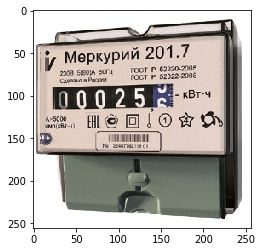

In [0]:
%%time
plt.imshow(gen[10][0][0])

CPU times: user 153 ms, sys: 4.3 ms, total: 158 ms
Wall time: 161 ms


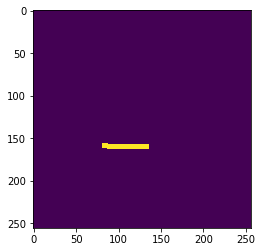

In [0]:
%%time
plt.imshow(gen[10][1][0][:,:,1])

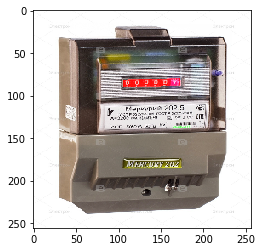

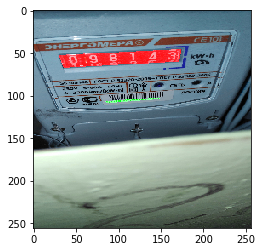

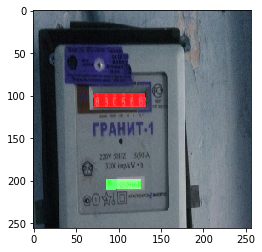

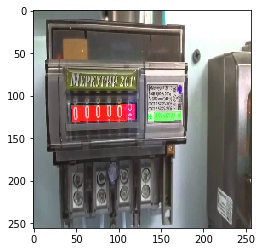

In [0]:
for i in range(1):
  g=gen[i]
  for j in range(4):
    
    plt.subplots()
    im=g[0][j]
    seg=g[1][j]
    np.putmask(im[:,:,0],seg[:,:,0]>0,1)
    np.putmask(im[:,:,1],seg[:,:,1]>0,1)
    plt.imshow(im)
    #print(i,j,np.max(im),np.max(seg))

# Training Segmentation

In [0]:
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
def unet(input_size = (32,32,1),descr=1,activation='sigmoid'):
    #descr=2
    inputs = Input(input_size)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = keras.layers.Dropout(0.5)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = keras.layers.Dropout(0.5)(conv5)

    up6 = keras.layers.Conv2D(int(512/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = keras.layers.Conv2D(int(256/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = keras.layers.Conv2D(int(128/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = keras.layers.Conv2D(int(64/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = keras.layers.Conv2D(2, 3, padding = 'same',activation = activation)(conv9)

    model = Model(input = inputs, output = conv10)
    
    model.summary()

    return model

In [0]:
def link_net(input_size = (32,32,1),descr=1,activation='sigmoid'):
    #descr=2
    inputs = Input(input_size)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = keras.layers.Dropout(0.5)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = keras.layers.Dropout(0.5)(conv5)

    up6 = keras.layers.Conv2D(int(512/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = keras.layers.add([drop4,up6])
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = keras.layers.Conv2D(int(256/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = keras.layers.add([conv3,up7])
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = keras.layers.Conv2D(int(128/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = keras.layers.add([conv2,up8])
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = keras.layers.Conv2D(int(64/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = keras.layers.add([conv1,up9])
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = keras.layers.Conv2D(2, 3, padding = 'same',activation = activation)(conv9)

    model = Model(input = inputs, output = conv10)
    
    model.summary()

    return model

In [0]:
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
def deep_block(kernels,inputs):
  conv1_inp = keras.layers.Conv2D(kernels, (3,1), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = keras.layers.Conv2D(kernels, (1,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_inp)
  conv1 = keras.layers.Conv2D(kernels, (3,1), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  conv1 = keras.layers.Conv2D(kernels, (1,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  conv1=keras.layers.add([conv1_inp,conv1])
  return conv1

def super_unet(input_size = (32,32,1),descr=1,activation='sigmoid'):
    #descr=2
    inputs = keras.layers.Input(input_size)
    conv1 = deep_block(int(64/descr),inputs)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = deep_block(int(128/descr),pool1)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = deep_block(int(256/descr),pool2)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = deep_block(int(512/descr),pool3)
    drop4 = keras.layers.Dropout(0.5)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv4 = deep_block(int(1024/descr),pool4)
    drop5 = keras.layers.Dropout(0.5)(conv4)

    up6 = keras.layers.Conv2D(int(512/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = deep_block(int(512/descr),merge6)

    up7 = keras.layers.Conv2D(int(256/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = deep_block(int(256/descr),merge7)

    up8 = keras.layers.Conv2D(int(128/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = deep_block(int(128/descr),merge8)

    up9 = keras.layers.Conv2D(int(64/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = deep_block(int(64/descr),merge9)

    conv10 = keras.layers.Conv2D(2, 3, padding = 'same',activation = activation)(conv9)

    model = Model(input = inputs, output = conv10)
    
    model.summary()

    return model

In [0]:
#tf.keras.utils.plot_model(model)

In [0]:
#!git clone https://github.com/bonlime/keras-deeplab-v3-plus

In [0]:
#!mv keras-deeplab-v3-plus deeplab

In [0]:
#from deeplab.model import Deeplabv3
#model = Deeplabv3(input_shape=(512, 512, 3),weights=None, classes=2,activation='sigmoid') 

In [0]:
#model=unet(input_size=(256,256,3),descr=8,activation='sigmoid')
model=super_unet(input_size=(256,256,3),descr=8,activation='sigmoid')
#model=link_net(input_size=(512,512,3),descr=8,activation='sigmoid')






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 8)  200         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 8)  200         conv

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [0]:
#model=keras.models.load_model('unet_seg.h5')

In [0]:
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [0]:
model.compile('adam',loss=bce_dice_loss,metrics=['acc',dice_coef])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
check=keras.callbacks.ModelCheckpoint('res_weights.h5', monitor='val_loss',save_best_only=True)

In [0]:
history = model.fit_generator(
    gen,
    validation_data=val,
    use_multiprocessing=False,
    workers=4,
    epochs=200,
    verbose=1,
    shuffle=True,
    callbacks=[check]
)




Epoch 1/200





255/255 [==============================] - 54s 212ms/step - loss: 0.8532 - acc: 0.9918 - dice_coef: 0.2863 - val_loss: 0.5886 - val_acc: 0.9953 - val_dice_coef: 0.4876
Epoch 2/200
255/255 [==============================] - 46s 178ms/step - loss: 0.5069 - acc: 0.9942 - dice_coef: 0.5746 - val_loss: 0.5845 - val_acc: 0.9914 - val_dice_coef: 0.4987
Epoch 3/200
255/255 [==============================] - 46s 179ms/step - loss: 0.4535 - acc: 0.9870 - dice_coef: 0.6206 - val_loss: 0.5806 - val_acc: 0.9875 - val_dice_coef: 0.5087
Epoch 4/200
255/255 [==============================] - 45s 176ms/step - loss: 0.4371 - acc: 0.9673 - dice_coef: 0.6336 - val_loss: 0.4452 - val_acc: 0.8104 - val_dice_coef: 0.6184
Epoch 5/200
255/255 [==============================] - 46s 182ms/step - loss: 0.4064 - acc: 0.9775 - dice_coef: 0.6618 - val_loss: 0.4694 - val_acc: 0.8340 - val_dice_coef: 0.6048
Epoch 6/200
255/255 [==============================] - 46s 180ms/step - loss: 0.3940 - acc: 

KeyboardInterrupt: ignored

In [0]:
model.load_weights('res_weights.h5')

In [0]:
#model.compile('adam',loss='binary_crossentropy',metrics=['acc'])

In [0]:
#model.save('u_net_seg.h5')

# Test Segmentation

In [0]:
%%time
test_val=model.predict(val[1][0],verbose=1)

4/4 [==============================] - 0s 66ms/step
CPU times: user 412 ms, sys: 6.99 ms, total: 419 ms
Wall time: 423 ms


In [0]:
test_val[1].shape

(256, 256, 2)

In [0]:
np.max(test_val[1,:,:,1])

0.0057413876

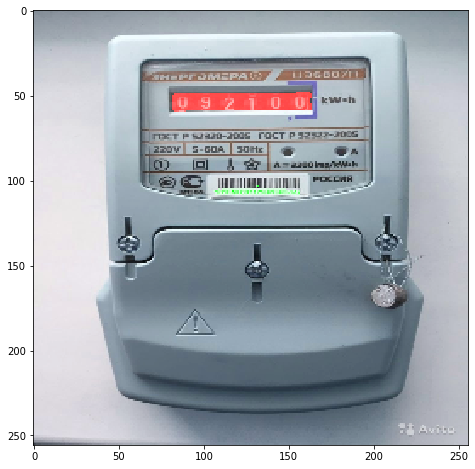

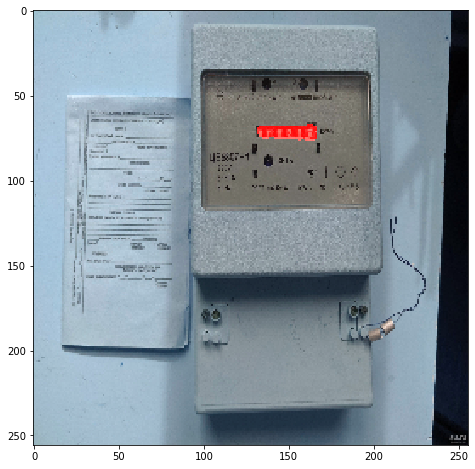

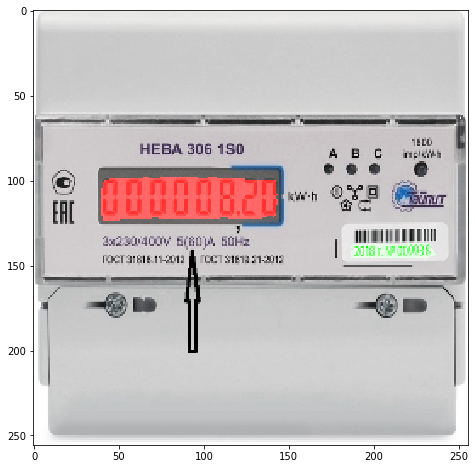

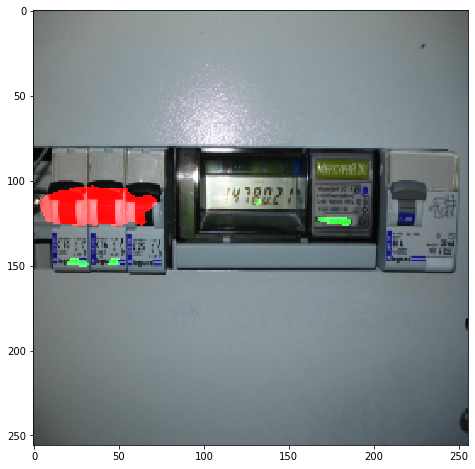

In [0]:
val_imgs=val[1][0]
for i in range(len(val_imgs)):
  mask=test_val[i]
  np.putmask(val_imgs[i,:,:,0],mask[:,:,0]>0.5,1)
  np.putmask(val_imgs[i,:,:,1],mask[:,:,1]>0.5,1)
  fig,axs=plt.subplots(1,figsize=(8,8))
  axs.imshow(val_imgs[i,:,:])

# Convert Segmentation

In [0]:
model.compile('adam',loss='binary_crossentropy',metrics=['acc'])
model.save('u_net_seg.h5')

In [0]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import CustomObjectScope
#def relu6(x):
 # return K.relu(x, max_value=6)
#with CustomObjectScope({'relu6': relu6}):
   # model = load_model('weights.hdf5')
# Convert the mogff
converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file('u_net_seg.h5')
converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.target_spec.supported_types=[tf.float32]
tflite_model = converter.convert()
    
    # Create the gfftflite model file
tflite_model_name = "u_net_seg_f32.tflite"
open(tflite_model_name, "wb").write(tflite_model)

INFO:tensorflow:Froze 82 variables.
INFO:tensorflow:Converted 82 variables to const ops.


398912

# Data Generator OCR

In [0]:
pretrain_df=train_df[train_df['is_serial_vertical']==False]
pretrain_df=pretrain_df[pretrain_df['value_r'].str.contains('\(')==False]
pretrain_df=pretrain_df[pretrain_df['value_r'].str.contains('-')==False]
pretrain_df=pretrain_df[pretrain_df['value_r'].str.contains('_')==False]
pretrain_df=pretrain_df[pretrain_df['value_r'].str.contains(' ')==False]



#pretrain_df=pretrain_df[pretrain_df['value_s'].str.contains('\\n')==False]
#pretrain_df=pretrain_df[pretrain_df['value_s'].str.contains('#')==False]
#pretrain_df=pretrain_df[pretrain_df['value_s'].str.contains('\.')==False]
#pretrain_df=pretrain_df[pretrain_df['value_s'].str.contains(':')==False]
#pretrain_df=pretrain_df[pretrain_df['value_s'].str.contains('N')==False]
#pretrain_df=pretrain_df[pretrain_df['value_s'].str.contains(' ')==False]

#pretrain_df=train_df[train_df['is_serial_vertical']==False]

In [0]:
train_df['value_r'].str.contains('\(').sum()

6

In [0]:
len(pretrain_df)

1173

In [0]:
train_files, val_files = train_test_split(
    pretrain_df, test_size=0.15, random_state=2019
)

In [0]:
pretrain_df['value_r'].unique()

array(['002229', '000011', '0000797', '00000298', '563184', '07331',
       '0006387', '176133', '000019', '042145', '025767', '0000013',
       '00228263', '000007', '000003', '0122900', '403590', '179707',
       '116564', '133244', '052179', '0009474', '062521', '000009',
       '022262', '0229597', '0002474', '15102011', '0032774', '004318',
       '062261', '000002', '0000532', '053918', '000026', '0000002',
       '004892', '000200', '005879', '035065', '00115369', '051735',
       '000474', '00003', '0015421', '0005367', '00000045', '000004',
       '326933', '010884', '1729', '002642', '0000', '49265', '3272',
       '136833', '0931313', '0038351', '236366', '273411', '092100',
       '0045829', '092399', '000029', '0000003', '042775', '000440',
       '0035595', '000020', '1385306', '0022817', '0015692', '044728',
       '014370', '211206', '0000391', '0030074', '000299', '067037',
       '000263', '0653371', '0001721', '096837', '000005', '0000017',
       '184190', '196351',

In [0]:
max_len_str=pretrain_df['value_r'].str.len().max()

In [0]:
max_len_str

8

In [0]:
letters_n=[]
lres=pretrain_df['value_r'].astype(str).apply(list)
for l in lres:
  letters_n+=l
letters_n=sorted(list(set(letters_n)))

In [0]:
letters_n

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [0]:
letters_s=[]
lres=pretrain_df['value_s'].astype(str).apply(list)
for l in lres:
  letters_s+=l
letters_s=sorted(list(set(letters_s)))

In [0]:
letters_s

['\n',
 ' ',
 '#',
 '.',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 'A',
 'M',
 'N',
 'O',
 'a',
 'n',
 'o',
 'Б',
 'Г',
 'П',
 'г',
 'р',
 'э']

In [0]:
def text_to_labels(text,is_serial=False):
  if(is_serial):
    return list(map(lambda x: letters_s.index(x), text))
  else:
    return list(map(lambda x: letters_n.index(x), text))

In [0]:
#from scipy.ndimage import imread
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, df,  mode='fit',
                 base_path = '../input/recursion-cellular-image-classification/train',
                 batch_size=32, dim=(64, 512), n_channels=1,size=9,
                 rotation_range=0, fill_mode='nearest',
                 vertical_flip=False, horizontal_flip=False, rescale=1/255.,
                 n_classes=5, random_state=2019, shuffle=True,len_seq=32,len_line=8,is_serial=False):
      

        self.is_serial=is_serial


        self.dim = dim
        self.batch_size = batch_size
        self.df=df
        self.mode = mode
        self.size=size
        self.base_path = base_path
        self.rotation_range=rotation_range
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale = rescale
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
        self.random_state = random_state
        
        self.len_seq=len_seq
        np.random.seed(self.random_state)
        self.on_epoch_end()

        if(is_serial):
          self.len_line=16
        else:
          self.len_line=8

        

    def __len__(self):
        'Denotes the number of batches per epoch'
        #print('len')
        return int((len(self.df) / self.batch_size))

    def __getitem__(self, index):

        batch_files = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = self.__generate_y(batch_files)
            return [X, y,np.ones((self.batch_size, 1)) * self.len_seq,self.cur_data],np.zeros([self.batch_size,1])
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
        buf=np.empty((self.batch_size, self.dim[0],self.dim[1],3))

        for i in range(len(batch_files)):

          if self.mode == 'fit':
            b=cv2.imread(DATA_DIR+batch_files.iloc[i]['image'])
          else:
            b=cv2.imread(batch_files[i])

          b=cv2.resize(b,(self.dim[1],self.dim[0]))
          buf[i,]=b
          
        #buf = seq(images=buf.astype('uint8'))
        buf=buf*self.rescale
        return buf
    
    def __generate_y(self, batch_files):
        y=np.ones((self.batch_size,self.len_line))* 100
        self.cur_data=np.zeros((self.batch_size,1))
        for i in range(len(batch_files)):
          if(self.is_serial):
            data=batch_files.iloc[i]['value_s'].strip()
          else:
            data=batch_files.iloc[i]['value_r'].strip()
          #print(data)
          self.cur_data[i]=len(data)
          #print(data,self.cur_data[i])
          y[i,:len(data)]=text_to_labels(data,self.is_serial)
          #if((-1) in y[i,:len(self.cur_data[i])]):
          #  print(data,len(data))
        return y
    def rotate(self,image, angle):
      image_center = tuple(np.array(image.shape[1::-1]) / 2)
      rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
      result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
      return result

In [0]:
#from scipy.ndimage import imread
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, df,  mode='fit',
                 base_path = '../input/recursion-cellular-image-classification/train',
                 batch_size=32, dim=(64, 512), n_channels=1,size=9,
                 rotation_range=0, fill_mode='nearest',
                 vertical_flip=False, horizontal_flip=False, rescale=1/255.,
                 n_classes=5, random_state=2019, shuffle=True,len_seq=32,len_line=8,is_serial=False):
      

        self.is_serial=is_serial


        self.dim = dim
        self.batch_size = batch_size
        self.df=df
        self.mode = mode
        self.size=size
        self.base_path = base_path
        self.rotation_range=rotation_range
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale = rescale
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
        self.random_state = random_state
        
        self.len_seq=len_seq
        np.random.seed(self.random_state)
        self.on_epoch_end()

        if(is_serial):
          self.len_line=16
        else:
          self.len_line=8

        

    def __len__(self):
        'Denotes the number of batches per epoch'
        #print('len')
        return int((len(self.df) / self.batch_size))

    def __getitem__(self, index):

        batch_files = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = self.__generate_y(batch_files)
            return [X, y,np.ones((self.batch_size, 1)) * self.len_seq,self.cur_data],np.zeros([self.batch_size,1])
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
        buf=np.empty((self.batch_size, self.dim[0],self.dim[1],3))

        for i in range(len(batch_files)):

          if self.mode == 'fit':
            b=cv2.imread(READ_DIR+str(batch_files.iloc[i]['data_index'])+'.png')
          else:
            b=cv2.imread(batch_files[i])
          ##kernel = np.full((3,3),-1)
          #kernel[1,1]=9
          #b=cv2.filter2D(b,-1,kernel)
          b=cv2.resize(b,(self.dim[1],self.dim[0]))
          buf[i,]=b
          
        #buf = seq(images=buf.astype('uint8'))
        buf=buf*self.rescale
        return buf
    
    def __generate_y(self, batch_files):
        y=np.ones((self.batch_size,self.len_line))* 100
        self.cur_data=np.zeros((self.batch_size,1))
        for i in range(len(batch_files)):
          if(self.is_serial):
            data=batch_files.iloc[i]['value_s'].strip()
          else:
            data=batch_files.iloc[i]['value_r'].strip()
          #print(data)
          self.cur_data[i]=len(data)
          #print(data,self.cur_data[i])
          y[i,:len(data)]=text_to_labels(data,self.is_serial)
          #if((-1) in y[i,:len(self.cur_data[i])]):
          #  print(data,len(data))
        return y
    def rotate(self,image, angle):
      image_center = tuple(np.array(image.shape[1::-1]) / 2)
      rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
      result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
      return result

In [0]:
gen=DataGeneratorFull(train_files,batch_size=4,len_seq=32,dim=(64,512),is_serial=False)
val=DataGeneratorFull(val_files,batch_size=4,len_seq=32,dim=(64,512),is_serial=False)

In [0]:
%%time
g=gen.__getitem__(65)

CPU times: user 8.85 ms, sys: 923 µs, total: 9.77 ms
Wall time: 10.5 ms


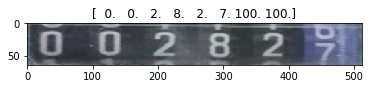

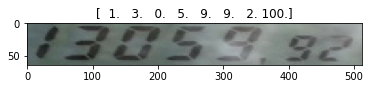

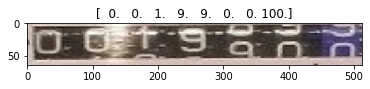

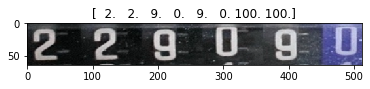

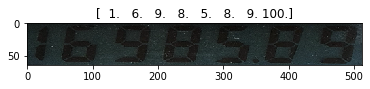

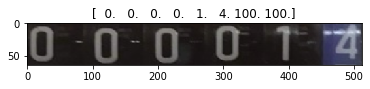

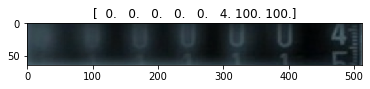

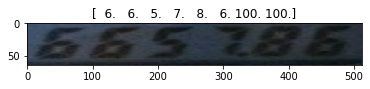

In [0]:
for i in range(2,4):
  g=gen[i]
  d=g[0][0]
  l=g[0][1]
  for j in range(len(d)):
    fig,axs=plt.subplots()
    plt.imshow(d[j])
    axs.set_title(str(l[j]))

In [0]:
img=d[0]
print(img.shape)
rows, cols = img.shape
crow,ccol = rows/2 , cols/2
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

(64, 512, 3)


ValueError: ignored

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


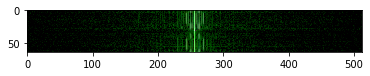

In [0]:
plt.imshow(magnitude_spectrum/np.max(magnitude_spectrum))

# Training OCR

In [0]:
from tensorflow.keras import backend as K
#from keras.layers import *
import tensorflow as tf
#import keras as keras
#import efficientnet.keras as efn
import keras.applications

def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, :, :]
    #print(labels.shape,y_pred.shape,input_length.shape,label_length.shape)
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def lstm_model(input_shape=(64,512,3), load=False):
    # Input Parameters
    

    # Network parameters
    conv_filters = 512
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 256


    downsample_factor = pool_size ** 2

    backbone=keras.applications.mobilenet_v2.MobileNetV2(input_shape=input_shape,include_top=False,weights='imagenet',pooling=None)


    backbone.summary()
    act = 'relu'
    input_data = keras.layers.Input(name='the_input', shape=input_shape, dtype='float32')
    #lnet=loc_net(input_shape=input_shape)
    #inner=STN(lnet,(64,512,3))(input_data)
    inner=backbone(input_data)

    #conv_to_rnn_dims=(32,1024)
    print(inner.shape)
    #inner = tf.keras.layers.Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    #print('reshape=',inner.shape)

    #inner=tf.keras.layers.LSTM(64,activation='relu',return_sequences=True)(inner)
    #print(inner.shape)

    #inner=tf.keras.layers.concatenate([gru_2,gru_2b])
    print(inner.shape)
    keras.models.Model(inputs=input_data, outputs=inner).summary()
    #inner = keras.layers.Reshape(target_shape=(64,512), name='reshape2')(inner)
    #inner = keras.layers.Reshape(target_shape=(32,1024), name='reshape2')(inner)
    #inner = keras.layers.Reshape(target_shape=(64,4096), name='reshape2')(inner)
    inner = keras.layers.Reshape(target_shape=(32,1280), name='reshape2')(inner)

    inner = keras.layers.Dense(len(letters_n)+1, kernel_initializer='he_normal',
                  name='dense4')(inner)
    y_pred = keras.layers.Activation('softmax', name='softmax')(inner)
    keras.models.Model(inputs=input_data, outputs=y_pred).summary()

    labels = keras.layers.Input(name='the_labels', shape=[max_len_str], dtype='float32')
    input_length = keras.layers.Input(name='input_length', shape=[1], dtype='int64')
    label_length = keras.layers.Input(name='label_length', shape=[1], dtype='int64')

    loss_out = keras.layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    model = keras.models.Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    return model

In [0]:
model=lstm_model((64,512,3))

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, 64, 512, 3)   0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 65, 513, 3)   0           input_15[0][0]                   
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 32, 256, 32)  864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 32, 256, 32)  128         Conv1[0][0]                      
_______________________________________________________________________________

In [0]:
model.summary()

Model: "model_41"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 64, 512, 3)   0                                            
__________________________________________________________________________________________________
mobilenetv2_1.00_224 (Model)    (None, 2, 16, 1280)  2257984     the_input[0][0]                  
__________________________________________________________________________________________________
reshape2 (Reshape)              (None, 32, 1280)     0           mobilenetv2_1.00_224[1][0]       
__________________________________________________________________________________________________
dense4 (Dense)                  (None, 32, 11)       14091       reshape2[0][0]                   
___________________________________________________________________________________________

In [0]:
from keras.optimizers import SGD
sgd = tf.keras.optimizers.SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer='adam')

In [0]:
check=keras.callbacks.ModelCheckpoint('mobilenet_ocr.h5', monitor='val_loss',save_best_only=True)

In [0]:
history = model.fit_generator(
    gen,
    validation_data=val,
    use_multiprocessing=False,
    workers=4,
    epochs=50,
    verbose=1,
    #shuffle=True,
    callbacks=[check]
)

Epoch 1/50
249/249 [==============================] - 45s 181ms/step - loss: 12.2258 - val_loss: 20.8795
Epoch 2/50
249/249 [==============================] - 19s 78ms/step - loss: 4.9194 - val_loss: 34.1095
Epoch 3/50
249/249 [==============================] - 19s 77ms/step - loss: 2.3154 - val_loss: 8.1496
Epoch 4/50
249/249 [==============================] - 20s 80ms/step - loss: 1.3875 - val_loss: 7.9234
Epoch 5/50
249/249 [==============================] - 20s 81ms/step - loss: 1.1025 - val_loss: 4.6935
Epoch 6/50
249/249 [==============================] - 20s 81ms/step - loss: 0.9124 - val_loss: 10.5629
Epoch 7/50
249/249 [==============================] - 21s 85ms/step - loss: 1.0487 - val_loss: 31.1678
Epoch 8/50
249/249 [==============================] - 21s 85ms/step - loss: 0.9293 - val_loss: 10.7717
Epoch 9/50
249/249 [==============================] - 20s 79ms/step - loss: 0.6496 - val_loss: 11.7965
Epoch 10/50
249/249 [==============================] - 20s 80ms/step - los

In [0]:


lt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

In [0]:
history = model.fit_generator(
    gen,
    validation_data=val,
    use_multiprocessing=False,
    workers=4,
    epochs=50,
    verbose=1,
    #shuffle=True,
    callbacks=[check]
)

In [0]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])

In [0]:
json_config = model.to_json()
with open('mobilenet_ocr.json', 'w+') as json_file:
    json_file.write(json_config)

In [0]:
model.load_weights('mobilenet_ocr.h5')

# Take Predict OCR Model

In [0]:
def mask_to_number(mask,trig=False):
  if(trig):
    size=len(mask)
  else:
    size=len(mask[0])
  res=[]
  for i in range(size):
    if(trig):
      res.append(np.argmax(mask[i]))
    else:
      res.append(np.argmax(mask[0,i]))
  return res

In [0]:
model.input

[<tf.Tensor 'the_input_1:0' shape=(?, 64, 512, 3) dtype=float32>,
 <tf.Tensor 'the_labels_1:0' shape=(?, 8) dtype=float32>,
 <tf.Tensor 'input_length_1:0' shape=(?, 1) dtype=int64>,
 <tf.Tensor 'label_length_1:0' shape=(?, 1) dtype=int64>]

In [0]:
pred_model=tf.keras.models.Model(inputs=[model.input[0]],outputs=[model.layers[-5].output])

In [0]:
pred_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, 64, 512, 3)]      0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 2, 16, 1024)       3228864   
_________________________________________________________________
reshape2 (Reshape)           (None, 64, 512)           0         
_________________________________________________________________
dense4 (Dense)               (None, 64, 11)            5643      
_________________________________________________________________
softmax (Activation)         (None, 64, 11)            0         
Total params: 3,234,507
Trainable params: 3,212,619
Non-trainable params: 21,888
_________________________________________________________________


In [0]:
a=pred_model.predict(np.zeros((1,64,512,3)))

In [0]:
json_config = pred_model.to_json()
with open('mobilenet_ocr_pred.json', 'w+') as json_file:
    json_file.write(json_config)

In [0]:
pred_model.save_weights("mobilenet_ocr_pred.h5")

In [0]:
pred_model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       [(None, 64, 512, 3)]      0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 2, 16, 1024)       3228864   
_________________________________________________________________
reshape2 (Reshape)           (None, 64, 512)           0         
_________________________________________________________________
dense4 (Dense)               (None, 64, 11)            5643      
_________________________________________________________________
softmax (Activation)         (None, 64, 11)            0         
Total params: 3,234,507
Trainable params: 3,212,619
Non-trainable params: 21,888
_________________________________________________________________


In [0]:
pred_model.input_shape

(None, 64, 512, 3)

In [0]:
pred_model.output_shape

(None, 64, 11)

# Testing OCR

# Convert OCR

# Data Generator SegmentWithKeyPoints


In [0]:
pretrain_df=train_df[train_df['is_serial_vertical']==False]

In [0]:
pretrain_df.head()

,annotation,image,jdata,reader_x,reader_y,serial_x,serial_y,value_r,value_s,data_index,height,width,is_serial_vertical
0,/data/annotations/segmentation/good (338).jpg/...,/data/original_images/good (338).jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[175, 342, 341, 174]","[190, 187, 207, 209]","[320, 399, 400, 320]","[316, 313, 325, 328]",002229,211330,0,600,800,False
1,/data/annotations/segmentation/1655.jpg/157975...,/data/original_images/1655.jpg,"{'filename': '1655.jpg', 'size': 100682, 'regi...","[179, 348, 349, 180]","[234, 232, 261, 262]","[289, 389, 389, 289]","[427, 427, 444, 444]",000011,08478375,1,766,564,False
2,/data/annotations/segmentation/box_268_020.jpg...,/data/original_images/box_268_020.jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[169, 1004, 995, 161]","[400, 430, 595, 572]","[672, 1206, 1206, 672]","[807, 811, 872, 869]",0000797,305224,2,1229,1373,False
3,/data/annotations/segmentation/1450802582_Schi...,/data/original_images/1450802582_Schietchik-el...,"{'size': -1, 'regions': [{'shape_attributes': ...","[133, 133, 444, 447]","[141, 199, 199, 136]","[65, 67, 230, 229]","[372, 400, 394, 370]",00000298,60871420,3,441,640,False
4,/data/annotations/segmentation/IMG_20191117_15...,/data/original_images/IMG_20191117_152218.jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[1690, 2521, 2537, 1691]","[1965, 1947, 2110, 2120]","[2759, 3237, 3237, 2761]","[2091, 2093, 2153, 2147]",563184,0524568809,4,3120,4160,False


In [0]:
def str2arr(str):
  buf_str=str.replace('[','').replace(']','')
  res=np.array(buf_str.split(',')).astype(int)
  return res
def sort_points(points):
  cx=0
  cy=0
  for p in points:
    cx+=p[0]
    cy+=p[1]
  cx=cx/4
  cy=cy/4
  ltp=[0,0]
  lbp=[0,0]
  rtp=[0,0]
  rbp=[0,0]
  for p in points:
    if(p[0]<cx and p[1]>cy):
      ltp=p
    if(p[0]<cx and p[1]<cy):
      lbp=p
    if(p[0]>cx and p[1]>cy):
      rtp=p
    if(p[0]>cx and p[1]<cy):
      rbp=p
  return np.array([ltp,lbp,rbp,rtp])
def get_points(val_x,val_y):
  
  x=str2arr(val_x)
  y=str2arr(val_y)
  res=np.zeros((len(x),2))
  res[:,0]=x
  res[:,1]=y

  return np.array(sort_points(res))

In [0]:
#from scipy.ndimage import imread
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, df, mode='fit',
                 base_path = '../input/recursion-cellular-image-classification/train',
                 batch_size=32, dim=(640, 512), n_channels=1,size=9,
                 rotation_range=0, fill_mode='nearest',
                 vertical_flip=False, horizontal_flip=False, rescale=1/255.,
                 n_classes=5, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df=df
        self.mode = mode
        self.size=size
        self.base_path = base_path
        self.rotation_range=rotation_range
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale = rescale
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((len(self.df) / self.batch_size))

    def __getitem__(self, index):
        self.cur_ind=index

        batch_files = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = self.__generate_y(batch_files)
            return X, y
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
        buf=np.empty((self.batch_size, self.dim[0],self.dim[1],3))
        #self.buf_width=np.zeros((self.batch_size,))
        #self.buf_height=np.zeros((self.batch_size,))
        for i in range(len(batch_files)):
          if self.mode == 'fit':
            b=cv2.imread(DATA_DIR+batch_files.iloc[i]['image'])
            #b=cv2.imread(SEG_DIR+str(batch_files.iloc[i]['data_index'])+'.png', cv2.IMREAD_UNCHANGED)
          else:
            b=cv2.imread(batch_files[i])
          #self.buf_width[i],self.buf_height[i]=b.shape[0],b.shape[1]
          #print('THIS ERRROR????',b.shape)
          b=cv2.resize(b,(self.dim[1],self.dim[0]))
          b=b*self.rescale
          buf[i,]=b
          

        return buf
    
    def __generate_y(self, batch_files):
        buf=np.empty((self.batch_size, self.dim[0],self.dim[1],2))
        advance_buf=np.zeros((self.batch_size,8,2))
        for i in range(len(batch_files)):
            bf=batch_files.iloc[i]
            #print(SEG_DIR+str(batch_files.iloc[i]['data_index'])+'.png')
            b=cv2.imread(SEG_DIR+str(bf['data_index'])+'.png', cv2.IMREAD_UNCHANGED)
            b=cv2.resize(b,(self.dim[1],self.dim[0]))
            
            cbm,_=cv2.findContours(b[:,:,0], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            rect_r =cv2.boundingRect(cbm[0])
            cbm,_=cv2.findContours(b[:,:,1], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            rect_s =cv2.boundingRect(cbm[0])

            advance_buf[i,0]=[rect_r[0],rect_r[1]]
            advance_buf[i,1]=[rect_r[0]+rect_r[2],rect_r[1]]
            advance_buf[i,2]=[rect_r[0]+rect_r[2],rect_r[1]+rect_r[3]]
            advance_buf[i,3]=[rect_r[0],rect_r[1]+rect_r[3]]

            advance_buf[i,4]=[rect_s[0],rect_s[1]]
            advance_buf[i,5]=[rect_s[0]+rect_s[2],rect_s[1]]
            advance_buf[i,6]=[rect_s[0]+rect_s[2],rect_s[1]+rect_s[3]]
            advance_buf[i,7]=[rect_s[0],rect_s[1]+rect_s[3]]

            #advance_reader=np.array(get_points(bf['reader_x'],bf['reader_y']))
            #advance_serial=np.array(get_points(bf['reader_x'],bf['reader_y']))
            #print(self.cur_ind,self.buf_width[i],self.buf_height[i])
            #advance_buf[i,:4]=advance_reader
            #advance_buf[i,4:]=advance_serial
            advance_buf[i,:,0]=advance_buf[i,:,0]/self.dim[0]
            advance_buf[i,:,1]=advance_buf[i,:,1]/self.dim[1]
            #b=b*self.rescale
            #buf[i,:,:,0]=b[:,:,0]
            #buf[i,:,:,1]=b[:,:,1]
        return advance_buf


In [0]:
#from scipy.ndimage import imread
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, df, mode='fit',
                 base_path = '../input/recursion-cellular-image-classification/train',
                 batch_size=32, dim=(640, 512), n_channels=1,size=9,
                 rotation_range=0, fill_mode='nearest',
                 vertical_flip=False, horizontal_flip=False, rescale=1/255.,
                 n_classes=5, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df=df
        self.mode = mode
        self.size=size
        self.base_path = base_path
        self.rotation_range=rotation_range
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale = rescale
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((len(self.df) / self.batch_size))

    def __getitem__(self, index):
        self.cur_ind=index

        batch_files = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = self.__generate_y(batch_files)
            return X, y
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
        buf=np.empty((self.batch_size, self.dim[0],self.dim[1],3))
        #self.buf_width=np.zeros((self.batch_size,))
        #self.buf_height=np.zeros((self.batch_size,))
        for i in range(len(batch_files)):
          if self.mode == 'fit':
            b=cv2.imread(DATA_DIR+batch_files.iloc[i]['image'])
            #b=cv2.imread(SEG_DIR+str(batch_files.iloc[i]['data_index'])+'.png', cv2.IMREAD_UNCHANGED)
          else:
            b=cv2.imread(batch_files[i])
          #self.buf_width[i],self.buf_height[i]=b.shape[0],b.shape[1]
          #print('THIS ERRROR????',b.shape)
          b=cv2.resize(b,(self.dim[1],self.dim[0]))
          b=b*self.rescale
          buf[i,]=b
          

        return buf
    
    def __generate_y(self, batch_files):
        buf=np.empty((self.batch_size, self.dim[0],self.dim[1],2))
        advance_buf=np.zeros((self.batch_size,4,2))
        for i in range(len(batch_files)):
            bf=batch_files.iloc[i]
            #print(SEG_DIR+str(batch_files.iloc[i]['data_index'])+'.png')
            b=cv2.imread(SEG_DIR+str(bf['data_index'])+'.png', cv2.IMREAD_UNCHANGED)
            b=cv2.resize(b,(self.dim[1],self.dim[0]))
            
            cbm,_=cv2.findContours(b[:,:,0], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            rect_r =cv2.boundingRect(cbm[0])
            cbm,_=cv2.findContours(b[:,:,1], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            rect_s =cv2.boundingRect(cbm[0])

            advance_buf[i,0]=[rect_r[0],rect_r[1]]
            advance_buf[i,1]=[rect_r[2],rect_r[3]]
            #advance_buf[i,2]=[rect_r[0]+rect_r[2],rect_r[1]+rect_r[3]]
            #advance_buf[i,3]=[rect_r[0],rect_r[1]+rect_r[3]]

            advance_buf[i,2]=[rect_s[0],rect_s[1]]
            advance_buf[i,3]=[rect_s[2],rect_s[3]]
           #advance_buf[i,6]=[rect_s[0]+rect_s[2],rect_s[1]+rect_s[3]]
            #advance_buf[i,7]=[rect_s[0],rect_s[1]+rect_s[3]]

            #advance_reader=np.array(get_points(bf['reader_x'],bf['reader_y']))
            #advance_serial=np.array(get_points(bf['reader_x'],bf['reader_y']))
            #print(self.cur_ind,self.buf_width[i],self.buf_height[i])
            #advance_buf[i,:4]=advance_reader
            #advance_buf[i,4:]=advance_serial
            advance_buf[i,:,0]=advance_buf[i,:,0]/self.dim[0]
            advance_buf[i,:,1]=advance_buf[i,:,1]/self.dim[1]
            #b=b*self.rescale
            #buf[i,:,:,0]=b[:,:,0]
            #buf[i,:,:,1]=b[:,:,1]
        return advance_buf

In [0]:
train_files, val_files = train_test_split(
    pretrain_df, test_size=0.15, random_state=2019
)

In [0]:
gen=DataGeneratorFull(train_files,dim=(256,256),batch_size=16)
val=DataGeneratorFull(val_files,dim=(256,256),batch_size=16)

In [0]:
gen[4][1]

array([[[0.3515625 , 0.27734375],
        [0.234375  , 0.0546875 ],
        [0.75390625, 0.296875  ],
        [0.08203125, 0.0234375 ]],

       [[0.27734375, 0.484375  ],
        [0.37890625, 0.08984375],
        [0.34765625, 0.65234375],
        [0.1640625 , 0.03515625]],

       [[0.2109375 , 0.4453125 ],
        [0.44921875, 0.08984375],
        [0.0859375 , 0.67578125],
        [0.25      , 0.03515625]],

       [[0.21875   , 0.3125    ],
        [0.2109375 , 0.0390625 ],
        [0.3984375 , 0.5234375 ],
        [0.1015625 , 0.0234375 ]],

       [[0.2734375 , 0.42578125],
        [0.3359375 , 0.08984375],
        [0.27734375, 0.59765625],
        [0.15625   , 0.0234375 ]],

       [[0.33984375, 0.44921875],
        [0.32421875, 0.11328125],
        [0.36328125, 0.5703125 ],
        [0.13671875, 0.04296875]],

       [[0.1171875 , 0.43359375],
        [0.55859375, 0.1328125 ],
        [0.00390625, 0.6953125 ],
        [0.31640625, 0.03515625]],

       [[0.35546875, 0.28515625],


# Training SegmentWithKeyPoints


In [0]:
def unet(input_size = (32,32,1),descr=1,activation='sigmoid'):
    #descr=2
    inputs = keras.layers.Input(input_size)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = keras.layers.Dropout(0.5)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = keras.layers.Dropout(0.5)(conv5)

    up6 = keras.layers.Conv2D(int(512/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
    merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = keras.layers.Conv2D(int(256/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
    merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = keras.layers.Conv2D(int(128/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
    merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = keras.layers.Conv2D(int(64/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    #conv10 = keras.layers.Conv2D(2, 3, padding = 'same',activation = activation)(conv9)
    out=keras.layers.GlobalAveragePooling2D()(conv9)
    out=keras.layers.Dense(16,activation='relu')(out)
    out=keras.layers.Reshape((8,2))(out)

    model = Model(input = inputs, output = out)
    
    model.summary()

    return model

In [0]:
def key_model(input_shape = (32,32,1)):
    #descr=2
    inputs = keras.layers.Input(input_shape)
    out=keras.layers.Conv2D(1,7,strides=2,activation='relu',padding='same')(inputs)
    out=keras.layers.MaxPool2D((3,3))(out)
    out=keras.layers.Conv2D(16,5,strides=2,activation='relu',padding='same')(inputs)
    out=keras.layers.MaxPool2D((2,2))(out)
    out=keras.layers.Flatten()(out)
    out=keras.layers.Dense(8,activation='relu')(out)
    out=keras.layers.Reshape((4,2))(out)

    model=keras.models.Model(inputs=inputs,outputs=out)

    return model

In [0]:
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
def key_model(input_shape = (32,32,1)):
    #descr=2
    inputs = keras.layers.Input(input_shape)
    back=keras.applications.mobilenet_v2.MobileNetV2(input_shape=input_shape,include_top=False,pooling='max')
    out=back(inputs)
    out=keras.layers.Dense(256,activation='relu')(out)
    out=keras.layers.Dense(8,activation='relu')(out)
    out=keras.layers.Reshape((4,2))(out)

    model=keras.models.Model(inputs=inputs,outputs=out)

    return model

In [0]:
model=key_model(input_shape=(256,256,3))
#model=unet((256,256,3),descr=8)

/usr/local/lib/python3.6/dist-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [0]:
model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_39 (InputLayer)        (None, 256, 256, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 1280)              2257984   
_________________________________________________________________
dense_32 (Dense)             (None, 256)               327936    
_________________________________________________________________
dense_33 (Dense)             (None, 8)                 2056      
_________________________________________________________________
reshape_21 (Reshape)         (None, 4, 2)              0         
Total params: 2,587,976
Trainable params: 2,553,864
Non-trainable params: 34,112
_________________________________________________________________


In [0]:
model.compile('adam',loss='mae',metrics=['acc','mse'])

In [0]:
check=keras.callbacks.ModelCheckpoint('res_weights.h5', monitor='val_loss',save_best_only=True)

In [0]:
history = model.fit_generator(
    gen,
    validation_data=val,
    use_multiprocessing=False,
    workers=4,
    epochs=200,
    verbose=1,
    shuffle=True,
    callbacks=[check]
)

Epoch 1/200
63/63 [==============================] - 105s 2s/step - loss: 0.3030 - acc: 0.6496 - mean_squared_error: 0.2430 - val_loss: 0.2780 - val_acc: 0.6634 - val_mean_squared_error: 0.1185
Epoch 2/200
63/63 [==============================] - 37s 595ms/step - loss: 0.2816 - acc: 0.6528 - mean_squared_error: 0.1207 - val_loss: 0.2780 - val_acc: 0.6634 - val_mean_squared_error: 0.1185
Epoch 3/200
20/63 [========>.....................] - ETA: 42s - loss: 0.2806 - acc: 0.6516 - mean_squared_error: 0.1200

KeyboardInterrupt: ignored

In [0]:
model.load_weights('res_weights.h5')

In [0]:
test_val=model.predict(val[0][0])

In [0]:
test_val[2]

array([[0.29035366, 0.39949116],
       [0.3019281 , 0.07834072],
       [0.51962525, 0.5309076 ],
       [0.14714924, 0.09663676]], dtype=float32)

In [0]:
def create_mask_points(points,shape):
  mask=np.zeros(shape)
  points=points.copy()
  points[:,0]*=shape[0]
  points[:,1]*=shape[1]
  bpoints=np.zeros((4,2))
  bpoints[0]=points[0]
  bpoints[1]=[points[0][0]+points[1][0],points[0][1]]
  bpoints[2]=[points[0][0]+points[1][0],points[0][1]+points[1][1]]
  bpoints[3]=[points[0][0],points[0][1]+points[1][1]]
  print(points)
  cv2.fillPoly(mask,np.int32([bpoints]),255)
  #cv2.fillPoly(mask,np.int32([pts]),(1,0,0))
  return mask

In [0]:
def create_mask_points(points,shape):
  mask=np.zeros(shape)
  points=points.copy()
  points[:,0]*=shape[0]
  points[:,1]*=shape[1]
  print(points)
  cv2.fillPoly(mask,np.int32([points]),255)
  #cv2.fillPoly(mask,np.int32([pts]),(1,0,0))
  return mask

[[ 76.58126  108.558266]
 [ 77.29007   19.435465]]
[[135.65053  143.05788 ]
 [ 37.638332  25.672028]]
[[72.483185 93.85295 ]
 [80.12994  21.790054]]
[[128.40092  129.46855 ]
 [ 38.1699    18.352757]]
[[ 74.330536 102.26974 ]
 [ 77.293594  20.055225]]
[[133.02406  135.91234 ]
 [ 37.670204  24.73901 ]]
[[68.54698  88.85949 ]
 [75.18911  21.024588]]
[[121.69707  121.63274 ]
 [ 37.659595  18.913609]]


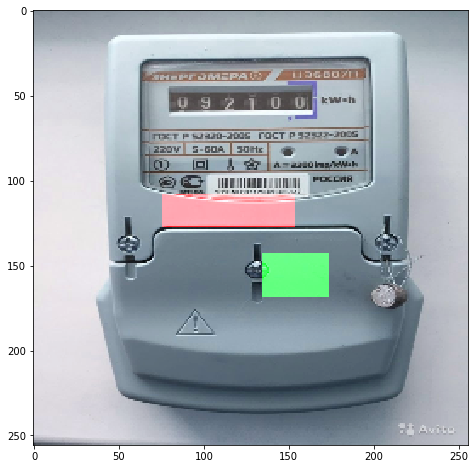

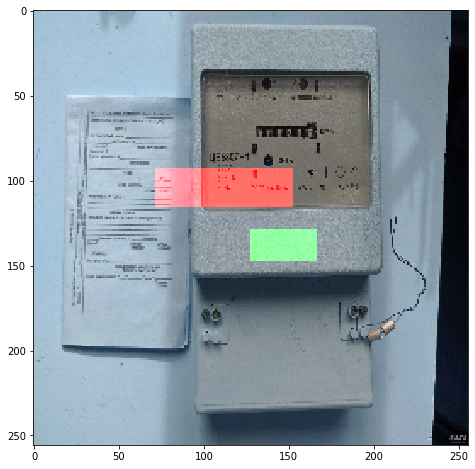

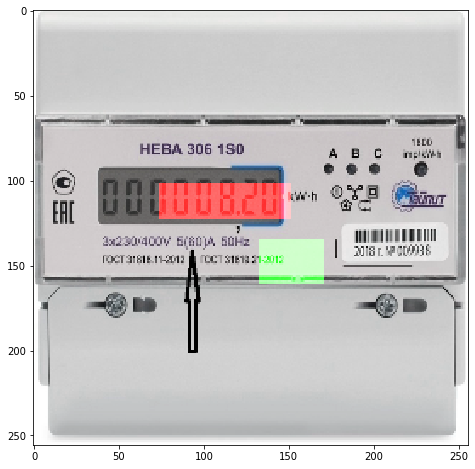

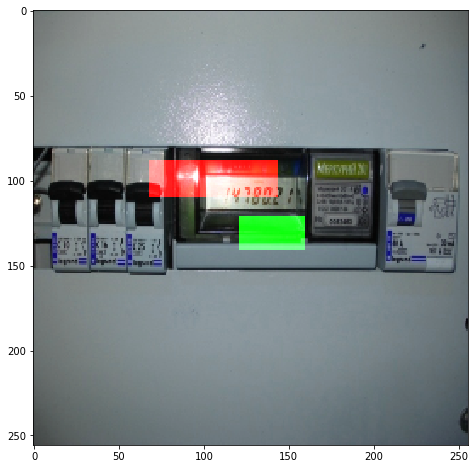

In [0]:
val_imgs=val[1][0]
for i in range(0,len(val_imgs)):
  if(np.max(test_val)<1):
    read_mask=create_mask_points(test_val[i,:2],(val_imgs[i].shape[0],val_imgs[i].shape[1]))
    serial_mask=create_mask_points(test_val[i,2:],(val_imgs[i].shape[0],val_imgs[i].shape[1]))
    np.putmask(val_imgs[i,:,:,0],read_mask>0,1)
    np.putmask(val_imgs[i,:,:,1],serial_mask>0,1)
  fig,axs=plt.subplots(1,figsize=(8,8))
  axs.imshow(val_imgs[i,:,:])


# Data Generator Spatial Transformer


In [0]:
pretrain_df=train_df[train_df['is_serial_vertical']==False]

In [0]:
pretrain_df.head()

,annotation,image,jdata,reader_x,reader_y,serial_x,serial_y,value_r,value_s,data_index,is_serial_vertical
0,/data/annotations/segmentation/good (338).jpg/...,/data/original_images/good (338).jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[175, 342, 341, 174]","[190, 187, 207, 209]","[320, 399, 400, 320]","[316, 313, 325, 328]",002229,211330,0,False
1,/data/annotations/segmentation/1655.jpg/157975...,/data/original_images/1655.jpg,"{'filename': '1655.jpg', 'size': 100682, 'regi...","[179, 348, 349, 180]","[234, 232, 261, 262]","[289, 389, 389, 289]","[427, 427, 444, 444]",000011,08478375,1,False
2,/data/annotations/segmentation/box_268_020.jpg...,/data/original_images/box_268_020.jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[169, 1004, 995, 161]","[400, 430, 595, 572]","[672, 1206, 1206, 672]","[807, 811, 872, 869]",0000797,305224,2,False
3,/data/annotations/segmentation/1450802582_Schi...,/data/original_images/1450802582_Schietchik-el...,"{'size': -1, 'regions': [{'shape_attributes': ...","[133, 133, 444, 447]","[141, 199, 199, 136]","[65, 67, 230, 229]","[372, 400, 394, 370]",00000298,60871420,3,False
4,/data/annotations/segmentation/IMG_20191117_15...,/data/original_images/IMG_20191117_152218.jpg,"{'size': -1, 'file_attributes': {}, 'regions':...","[1690, 2521, 2537, 1691]","[1965, 1947, 2110, 2120]","[2759, 3237, 3237, 2761]","[2091, 2093, 2153, 2147]",563184,0524568809,4,False


In [0]:
train_files, val_files = train_test_split(
    pretrain_df, test_size=0.15, random_state=2019
)

In [0]:
#from scipy.ndimage import imread
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, df, mode='fit',
                 base_path = '../input/recursion-cellular-image-classification/train',
                 batch_size=32, dim=(640, 512), n_channels=1,size=9,
                 rotation_range=0, fill_mode='nearest',
                 vertical_flip=False, horizontal_flip=False, rescale=1/255.,
                 n_classes=5, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df=df
        self.mode = mode
        self.size=size
        self.base_path = base_path
        self.rotation_range=rotation_range
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale = rescale
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((len(self.df) / self.batch_size))

    def __getitem__(self, index):

        batch_files = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = self.__generate_y(batch_files)
            return X, y
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
        buf=np.empty((self.batch_size, 1024,1024,1))
        for i in range(len(batch_files)):
          if self.mode == 'fit':
            b=cv2.imread(DATA_DIR+batch_files.iloc[i]['image'],cv2.IMREAD_GRAYSCALE)
          else:
            b=cv2.imread(batch_files[i])
          b=cv2.resize(b,(512,512))
          b=b*self.rescale
          buf[i,:,:,0]=b
          

        return buf
    
    def __generate_y(self, batch_files):
        buf=np.empty((self.batch_size, 512,512,2))
        for i in range(len(batch_files)):
            #print(SEG_DIR+str(batch_files.iloc[i]['data_index'])+'.png')
            b=cv2.imread(SEG_DIR+str(batch_files.iloc[i]['data_index'])+'.png')
            b=cv2.resize(b,(512,512))

            cbm,_=cv2.findContours(bm[:,:,0], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            rect =cv2.boundingRect(cbm[0])
            #b=b*self.rescale
            buf[i,:,:,0]=b[:,:,0]
            #buf[i,:,:,1]=b[:,:,1]
        return buf

In [0]:
def str2arr(str):
  buf_str=str.replace('[','').replace(']','')
  res=np.array(buf_str.split(',')).astype(int)
  return res
def sort_points(points):
  cx=0
  cy=0
  for p in points:
    cx+=p[0]
    cy+=p[1]
  cx=cx/4
  cy=cy/4
  for p in points:
    if(p[0]<cx and p[1]>cy):
      ltp=p
    if(p[0]<cx and p[1]<cy):
      lbp=p
    if(p[0]>cx and p[1]>cy):
      rtp=p
    if(p[0]>cx and p[1]<cy):
      rbp=p
  return np.array([ltp,lbp,rbp,rtp])


In [0]:
#from scipy.ndimage import imread
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, df, mode='fit',
                 base_path = '../input/recursion-cellular-image-classification/train',
                 batch_size=32, dim=(640, 512), n_channels=1,size=9,
                 rotation_range=0, fill_mode='nearest',
                 vertical_flip=False, horizontal_flip=False, rescale=1/255.,
                 n_classes=5, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df=df
        self.mode = mode
        self.size=size
        self.base_path = base_path
        self.rotation_range=rotation_range
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale = rescale
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((len(self.df) / self.batch_size))

    def __getitem__(self, index):

        batch_files = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = self.__generate_y(batch_files)
            return X, y
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
        buf=np.empty((self.batch_size, 512,512,3))
        for i in range(len(batch_files)):
          if self.mode == 'fit':
            b=cv2.imread(DATA_DIR+batch_files.iloc[i]['image'])
          else:
            b=cv2.imread(batch_files[i])
          b=cv2.resize(b,(512,512))
          b=b*self.rescale
          buf[i,]=b
          

        return buf
    
    def __generate_y(self, batch_files):
        buf=np.empty((self.batch_size, 6))
        for i in range(len(batch_files)):
            #print(SEG_DIR+str(batch_files.iloc[i]['data_index'])+'.png')
            b=cv2.imread(SEG_DIR+str(batch_files.iloc[i]['data_index'])+'.png', cv2.IMREAD_UNCHANGED)
            #b=cv2.resize(b,(512,512))
            #b=b*self.rescale
            cbm,_=cv2.findContours(b[:,:,0], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

            rect =cv2.boundingRect(cbm[0])
            #print(rect)
            p=np.array([[rect[0],rect[1]+rect[3]],[rect[0],rect[1]],[rect[0]+rect[2],rect[1]],[rect[0]+rect[2],rect[1]+rect[3]]]).astype('float32')
            tp=np.array([[0,64],[0,0],[512,0],[512,64]]).astype('float32')
            v=cv2.getAffineTransform(p[:3],tp[:3])
            #print(v)
            buf[i,]=v.flatten()
        return buf


In [0]:
gen=DataGeneratorFull(train_files,batch_size=4)
val=DataGeneratorFull(val_files,batch_size=4)

In [0]:
gen[0][0].shape

(4, 512, 512, 3)

CPU times: user 248 ms, sys: 869 µs, total: 248 ms
Wall time: 239 ms


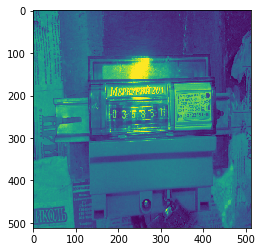

In [0]:
%%time
plt.imshow(gen[2][0][0][:,:,0])

In [0]:
#%%time
#plt.imshow(gen[10][1][0][:,:,0])

In [0]:
np.max(gen[3][1][0])

3.6312056737588656

In [0]:
warp_dst = cv2.warpAffine(gen[2][0][0][:,:,0], gen[2][1][0].reshape(2,3), (512, 64))

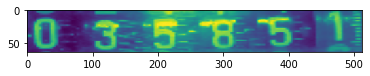

In [0]:
plt.imshow(warp_dst)

In [0]:
!pip install efficientnet

In [0]:
import efficientnet.keras as efn

# Training LocNet


In [0]:
import numpy as np
import tensorflow as tf
import keras
# initial bias_initializer
def loc_net(input_shape):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    w = np.zeros((64, 6), dtype='float32')
    weights = [w, b.flatten()]

    loc_input = keras.layers.Input(input_shape)

    loc_conv_1 = keras.layers.Conv2D(16, (5, 5), padding='same', activation='relu')(loc_input)
    loc_conv_2 = keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu')(loc_conv_1)
    #back=keras.applications.mobilenet_v2.MobileNetV2(input_shape=input_shape,pooling=None,weights='imagenet',include_top=False)
    #back=efn.EfficientNetB1(input_shape=input_shape,pooling=None,weights='imagenet',include_top=False)
    #loc_conv_2=back(loc_input)
    loc_fla = keras.layers.GlobalAveragePooling2D()(loc_conv_2)
    loc_fc_1 = keras.layers.Dense(64, activation='relu')(loc_fla)
    loc_fc_2 = keras.layers.Dense(6, weights=weights)(loc_fc_1)

    output = keras.models.Model(inputs=loc_input, outputs=loc_fc_2)

    return output

def loc_net(input_shape):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    w = np.zeros((64, 6), dtype='float32')
    weights = [w, b.flatten()]

    loc_input = Input(input_shape)

    loc_conv_1 = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(loc_input)
    loc_conv_2 = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(loc_conv_1)
    loc_pool_1=keras.layers.MaxPooling2D((2,2))(loc_conv_2)
    loc_conv_1 = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(loc_input)
    loc_conv_2 = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(loc_conv_1)
    loc_pool_4=keras.layers.MaxPooling2D((2,2))(loc_conv_2)
    loc_fla = keras.layers.GlobalAveragePooling2D()(loc_pool_4)
    loc_fc_1 = keras.layers.Dense(64, activation='relu')(loc_fla)
    loc_fc_2 = keras.layers.Dense(6, weights=weights)(loc_fc_1)

    output = Model(inputs=loc_input, outputs=loc_fc_2)

    return output

def loc_net(input_shape):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    w = np.zeros((64, 6), dtype='float32')
    weights = [w, b.flatten()]

    loc_input = Input(input_shape)

    back=keras.applications.mobilenet.MobileNet(input_shape=input_shape,pooling=None,weights='imagenet',include_top=False)
    #back=efn.EfficientNetB0(input_shape=input_shape,pooling=None,weights='imagenet',include_top=False)
    loc_pool_4=back(loc_input)
    loc_fla = keras.layers.GlobalAveragePooling2D()(loc_pool_4)
    loc_fc_1 = keras.layers.Dense(64, activation='relu')(loc_fla)
    loc_fc_2 = keras.layers.Dense(6, weights=weights)(loc_fc_1)

    output = Model(inputs=loc_input, outputs=loc_fc_2)

    return output

In [0]:
lnet=loc_net((512,512,3))

In [0]:
lnet.summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_31 (InputLayer)        (None, 512, 512, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512, 512, 3)       12        
_________________________________________________________________
efficientnet-b0 (Model)      (None, 16, 16, 1280)      4049564   
_________________________________________________________________
global_average_pooling2d_63  (None, 1280)              0         
_________________________________________________________________
dense_43 (Dense)             (None, 64)                81984     
_________________________________________________________________
dense_44 (Dense)             (None, 6)                 390       
Total params: 4,131,950
Trainable params: 4,089,928
Non-trainable params: 42,022
___________________________________________

In [0]:
lnet.compile('adam',loss='mse',metrics=['acc'])

In [0]:
lnet.fit_generator(gen,validation_data=val,epochs=20)

Epoch 1/20
146/255 [================>.............] - ETA: 1:35 - loss: 125483.2521 - acc: 0.2432

KeyboardInterrupt: ignored

In [0]:
res=lnet.predict(val[0][0])

In [0]:
def super_layer(inp,kernels=64,pool=(2,2)):

  out_adv=keras.layers.GlobalAveragePooling2D()(inp)
  out1=keras.layers.Conv2D(kernels,3,activation='relu',padding='same')(inp)
  out2=keras.layers.Conv2D(kernels,5,activation='relu',padding='same')(inp)
  out3=keras.layers.Conv2D(kernels,7,activation='relu',padding='same')(inp)
  out4=keras.layers.Conv2D(kernels,9,activation='relu',padding='same')(inp)
  out5=keras.layers.Conv2D(kernels,11,activation='relu',padding='same')(inp)
  out6=keras.layers.Conv2D(kernels,13,activation='relu',padding='same')(inp)
  out7=keras.layers.Conv2D(kernels,15,activation='relu',padding='same')(inp)
  out8=keras.layers.Conv2D(kernels,17,activation='relu',padding='same')(inp)
  out=keras.layers.add([out1,out2,out3,out4,out5,out6,out7,out8])
  out_pool=keras.layers.MaxPooling2D(pool)(out)

  out=keras.layers.GlobalAveragePooling2D()(out)

  return out_pool,out

def super_model(input_shape=(512,512,3),classes=6,activation=None):
  inp=keras.layers.Input(input_shape)
  out,slayer_1=super_layer(inp,kernels=32)
  out,slayer_2=super_layer(out,kernels=32)
  out,slayer_3=super_layer(out,kernels=32)
  out,slayer_4=super_layer(out,kernels=32)
  res_out=keras.layers.concatenate([slayer_1,slayer_2,slayer_3,slayer_4])
  res_out=Dense(classes*8,activation=activation)(res_out)
  res_out=Dense(classes,activation=activation)(res_out)
  model=keras.models.Model(inputs=inp,outputs=res_out)

  return model


In [0]:
lnet=super_model()

In [0]:
lnet.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_37 (InputLayer)           (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_177 (Conv2D)             (None, 512, 512, 32) 896         input_37[0][0]                   
__________________________________________________________________________________________________
conv2d_178 (Conv2D)             (None, 512, 512, 32) 2432        input_37[0][0]                   
__________________________________________________________________________________________________
conv2d_179 (Conv2D)             (None, 512, 512, 32) 4736        input_37[0][0]                   
___________________________________________________________________________________________

In [0]:
print(val[0][1][0])

[ 5.44680851e+00 -9.73644412e-16 -8.27914894e+02 -9.24283234e-16
  1.93939394e+00 -7.21454545e+02]


In [0]:
print(res[0])

[ 4.6186972e+00  3.2330791e-03 -1.5487462e+03  4.5360364e-02
  3.8903100e+00 -8.0205615e+02]


In [0]:
warp=res[1].reshape(2,3)

In [0]:
warp_dst = cv2.warpAffine(gen[0][0][1][:,:,0], warp, (512, 64))

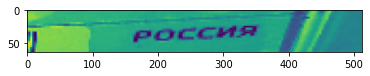

In [0]:
plt.imshow(warp_dst)

# Training Spatial Transformer

In [0]:
#!git clone https://github.com/sbillburg/CRNN-with-STN

Cloning into 'CRNN-with-STN'...
remote: Enumerating objects: 175, done.
remote: Total 175 (delta 0), reused 0 (delta 0), pack-reused 175
Receiving objects: 100% (175/175), 94.35 KiB | 3.93 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [0]:
#!rm -rf STN

In [0]:
#!mv CRNN-with-STN STN

In [0]:
#!pip install tf-nightly

     |████████████████████████████████| 466.8MB 36kB/s 
     |████████████████████████████████| 2.9MB 34.0MB/s 
     |████████████████████████████████| 460kB 48.4MB/s 
     |████████████████████████████████| 3.9MB 40.1MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
ERROR: tensorflow 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.11.0 which is incompatible.
ERROR: tb-nightly 2.2.0a20200205 has requirement grpcio>=1.24.3, but you'll have grpcio 1.15.0 which is incompatible.
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0
  Found existing installation: gast 0.2.2
    Uninstalling gast-0.2.2:
      Successfully uninstalled gast-0.2.2
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


In [0]:
#!pip install tensorflow==1.14.0

     |████████████████████████████████| 109.2MB 99kB/s 
     |████████████████████████████████| 3.2MB 39.9MB/s 
     |████████████████████████████████| 491kB 60.2MB/s 
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
!pip install stn

In [0]:
from stn import spatial_transformer_network as transformer

In [0]:
!git clone https://github.com/sbillburg/CRNN-with-STN

Cloning into 'CRNN-with-STN'...
remote: Enumerating objects: 175, done.
remote: Total 175 (delta 0), reused 0 (delta 0), pack-reused 175
Receiving objects: 100% (175/175), 94.35 KiB | 257.00 KiB/s, done.
Resolving deltas: 100% (95/95), done.


In [0]:
!mv CRNN-with-STN STN

In [0]:
from STN.STN.spatial_transformer import  SpatialTransformer as STN

In [0]:
import keras

In [0]:
!pip install efficientnet

In [0]:
import efficientnet.keras as efn

In [0]:
import numpy as np
import tensorflow as tf
import keras
# initial bias_initializer
def loc_net(input_shape):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    w = np.zeros((64, 6), dtype='float32')
    weights = [w, b.flatten()]

    loc_input = keras.layers.Input(input_shape)

    #loc_conv_1 = keras.layers.Conv2D(16, (5, 5), padding='same', activation='relu')(loc_input)
    #loc_conv_2 = keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu')(loc_conv_1)
    #back=keras.applications.mobilenet_v2.MobileNetV2(input_shape=input_shape,pooling=None,weights='imagenet',include_top=False)
    back=efn.EfficientNetB1(input_shape=input_shape,pooling=None,weights='imagenet',include_top=False)
    loc_conv_2=back(loc_input)
    loc_fla = keras.layers.GlobalAveragePooling2D()(loc_conv_2)
    loc_fc_1 = keras.layers.Dense(64, activation='relu')(loc_fla)
    loc_fc_2 = keras.layers.Dense(6, weights=weights)(loc_fc_1)

    output = keras.models.Model(inputs=loc_input, outputs=loc_fc_2)

    return output

def loc_net(input_shape):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    w = np.zeros((64, 6), dtype='float32')
    weights = [w, b.flatten()]

    loc_input = Input(input_shape)

    loc_conv_1 = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(loc_input)
    loc_conv_2 = keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(loc_conv_1)
    loc_pool_1=keras.layers.MaxPooling2D((2,2))(loc_conv_2)
    loc_conv_1 = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(loc_input)
    loc_conv_2 = keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(loc_conv_1)
    loc_pool_4=keras.layers.MaxPooling2D((2,2))(loc_conv_2)
    loc_fla = keras.layers.GlobalAveragePooling2D()(loc_pool_4)
    loc_fc_1 = keras.layers.Dense(64, activation='relu')(loc_fla)
    loc_fc_2 = keras.layers.Dense(6, weights=weights)(loc_fc_1)

    output = Model(inputs=loc_input, outputs=loc_fc_2)

    return output

In [0]:
#loc_net((64,64,3))

In [0]:
lnet=loc_net((1024,1024,1))

In [0]:
inp=keras.layers.Input((1024,1024,1))

out=STN(lnet,(64,512,1))(inp)
model=keras.models.Model(inputs=inp, outputs=out)

TypeError: ignored

In [0]:
out.get_shape()[1]

Dimension(64)

In [0]:
model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1024, 1024, 1)     0         
_________________________________________________________________
spatial_transformer_2 (Spati (None, 64, 512, 1)        157510    
Total params: 157,510
Trainable params: 157,510
Non-trainable params: 0
_________________________________________________________________


In [0]:
def ssim_loss(y_true, y_pred):
  return 1-tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

In [0]:
model.compile('adam',loss='mse',metrics=['acc',ssim_loss])

In [0]:
model.fit_generator(gen,validation_data=val,epochs=20)

Epoch 1/20
217/255 [========================>.....] - ETA: 21s - loss: 0.1170 - acc: 9.3493e-04 - ssim_loss: 0.6921

KeyboardInterrupt: ignored

In [0]:
res=model.predict(val[2][0])

In [0]:
np.max(res)

0.9586138

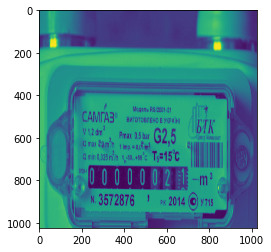

In [0]:
plt.imshow(val[2][0][0][:,:,0])

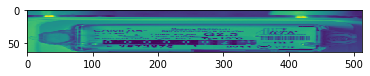

In [0]:
import cv2
plt.imshow(cv2.resize(val[2][0][0],(512,64)))

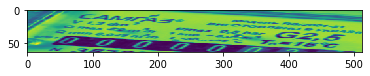

In [0]:
plt.imshow(res[0][:,:,0])

# Convert Spatial Transformer


In [0]:
model.save('CropNet.h5')

In [0]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import CustomObjectScope
def relu6(x):
  return K.relu(x, max_value=6)
with CustomObjectScope({'SpatialTransformer': STN}):
   # model = load_model('weights.hdf5')
# Convert the mogff
    converter = tf.compat.v1.lite.TFLiteConverter.from_keras_model_file('CropNet.h5')
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    
    # Create the gfftflite model file
    tflite_model_name = "link_net_seg.tflite"
    open(tflite_model_name, "wb").write(tflite_model)

TypeError: ignored

In [0]:
srcTri = np.array( [[0, 0], [512 - 1, 0], [0, 512 - 1]] ).astype(np.float32)
dstTri = np.array( [[0, 512*0.33], [512*0.85, 512*0.25], [512*0.15, 512*0.7]] ).astype(np.float32)
warp_mat = cv2.getAffineTransform(srcTri, dstTri)

In [0]:
warp_mat

array([[ 8.51663429e-01,  1.50293548e-01,  0.00000000e+00],
       [-8.01565689e-02,  3.70724045e-01,  1.68960007e+02]])

In [0]:
srcTri

array([[  0.,   0.],
       [511.,   0.],
       [  0., 511.]], dtype=float32)

In [0]:
dstTri

array([[  0.  , 168.96],
       [435.2 , 128.  ],
       [ 76.8 , 358.4 ]], dtype=float32)

In [0]:
def find_big_contour(im,seg):
  im=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
  mask1=seg[:,:,0]
  mask2=seg[:,:,1]
  cnt1,_=cv2.findContours(mask1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cnt2,_=cv2.findContours(mask2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  rect1=cv2.boundingRect(cnt1[0])
  rect2=cv2.boundingRect(cnt2[0])
  im_thresh=cv2.Canny(im,50,80)
  _,im_thresh=cv2.threshold(im_thresh,1,255,cv2.THRESH_BINARY)
  cnts,_=cv2.findContours(im_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  res=False
  for c in cnts:
    if(in_countour(c,[rect1,rect2])):
      
      res=True
      our_countour=cv2.boundingRect(c)
      #print(rect1,rect2,our_countour)
  #print(res)
  if(res):
    return res,our_countour
  else:
    return res,None

#StateNetDataset

In [0]:
def in_countour(cnt,rects):
  cnt_rect=cv2.boundingRect(cnt)
  #print('rect=',len(rects))
  for i in range(len(rects)):
    #print(i,cnt_rect,rects[i])
    if(rects[i][0]<cnt_rect[0] or rects[i][1]<cnt_rect[1] or rects[i][0]+rects[i][2]>cnt_rect[0]+cnt_rect[2] or rects[i][1]+rects[i][3]>cnt_rect[1]+cnt_rect[3]):
      return False
  return True

In [0]:
STATE_NET_DATA='/content/state_net/'

In [0]:
!rm -rf {STATE_NET_DATA}
!mkdir {STATE_NET_DATA}
statenet_train_df=[]
for i in tqdm(range(len(train_df))):
  d=train_df.iloc[i]
  #val_s=d['value_s']
  #val_r=d['value_r']
  im=cv2.imread(DATA_DIR+d['image'])
  seg=cv2.imread(SEG_DIR+str(d['data_index'])+'.png')
  trig,bcnt=find_big_contour(im,seg)
  d['is_big_contour']=trig
  if(trig):
    bcnt_im=im[bcnt[1]:bcnt[1]+bcnt[3],bcnt[0]:bcnt[0]+bcnt[2]]
    cv2.imwrite(STATE_NET_DATA+str(d['data_index'])+'.png',bcnt_im)
    d['big_contour_x']=bcnt[0]
    d['big_contour_y']=bcnt[1]
    d['big_contour_width']=bcnt[2]
    d['big_contour_height']=bcnt[3]

  statenet_train_df.append(d)
statenet_train_df=pd.DataFrame(statenet_train_df)

  0%|          | 0/1358 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [0]:
statenet_train_df=statenet_train_df[statenet_train_df['is_big_contour']==True]

# Data Generator StateNet


In [0]:
pretrain_df=statenet_train_df[statenet_train_df['is_serial_vertical']==False]

In [0]:
#from scipy.ndimage import imread
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, df, mode='fit',
                 base_path = '../input/recursion-cellular-image-classification/train',
                 batch_size=32, dim=(640, 512), n_channels=1,size=9,
                 rotation_range=0, fill_mode='nearest',
                 vertical_flip=False, horizontal_flip=False, rescale=1/255.,
                 n_classes=5, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df=df
        self.mode = mode
        self.size=size
        self.base_path = base_path
        self.rotation_range=rotation_range
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale = rescale
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((len(self.df) / self.batch_size))

    def __getitem__(self, index):

        batch_files = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        
        X, y = self.__generate_data(batch_files)
        
        if self.mode == 'fit':
            return X, y
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_data(self, batch_files):
        data_x=np.zeros((self.batch_size, self.dim[0],self.dim[1],3))
        data_y=np.zeros((self.batch_size,4))
        for i in range(len(batch_files)):
          d=batch_files.iloc[i]
          im=cv2.imread(DATA_DIR+d['image'])
          width=np.random.randint(60,im.shape[1])
          height=np.random.randint(60,im.shape[0])
          x=np.random.randint(0,im.shape[1]-width)
          y=np.random.randint(0,im.shape[0]-height)
          inp_im=im[y:y+height,x:x+width]
          inp_im=cv2.resize(inp_im,(self.dim[0],self.dim[1]))
          data_x[i]=inp_im*self.rescale
          data_y[i,0]=x<d['big_contour_x']
          data_y[i,1]=y<d['big_contour_y']
          data_y[i,2]=x+width>d['big_contour_x']+d['big_contour_width']
          data_y[i,3]=y+height>d['big_contour_y']+d['big_contour_height']
        return data_x,data_y

In [0]:
train_files, val_files = train_test_split(
    pretrain_df, test_size=0.15, random_state=2019
)

In [0]:
gen=DataGeneratorFull(train_files,dim=(512,512),batch_size=4)
val=DataGeneratorFull(val_files,dim=(512,512),batch_size=4)

In [0]:
g=gen[1]

In [0]:
g[1]

array([[1., 1., 1., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 1.],
       [1., 1., 1., 0.]])

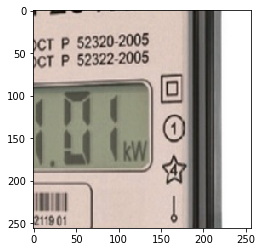

In [0]:
plt.imshow(g[0][1])

# StateNet Train

In [0]:
!pip install efficientnet

In [0]:
from efficientnet import keras as efn

In [0]:
def StateNetModel(input_shape=(512,512,3)):
  inp=keras.layers.Input(input_shape)
  #back=keras.applications.mobilenet.MobileNet(input_shape=input_shape,include_top=False,weights='imagenet',pooling='avg')
  back=efn.EfficientNetB0(input_shape=input_shape,include_top=False,weights='imagenet',pooling='avg')
  out=back(inp)
  out=Dense(256,activation='relu')(out)
  out=Dropout(0.5)(out)
  out=Dense(4,activation='sigmoid')(out)

  return keras.models.Model(inputs=inp,outputs=out)


In [0]:
model=StateNetModel((512,512,3))

In [0]:
model.compile('adam',loss='binary_crossentropy',metrics=['acc'])
check=keras.callbacks.ModelCheckpoint('res_weights.h5', monitor='val_loss',save_best_only=True)
history = model.fit_generator(
    gen,
    validation_data=val,
    use_multiprocessing=False,
    workers=4,
    epochs=200,
    verbose=1,
    shuffle=True,
    callbacks=[check]
)

Epoch 1/200
149/149 [==============================] - 63s 421ms/step - loss: 0.6729 - acc: 0.6174 - val_loss: 0.7402 - val_acc: 0.6322
Epoch 2/200
149/149 [==============================] - 40s 271ms/step - loss: 0.6200 - acc: 0.6707 - val_loss: 0.6695 - val_acc: 0.6635
Epoch 3/200
149/149 [==============================] - 41s 272ms/step - loss: 0.5862 - acc: 0.6896 - val_loss: 0.4930 - val_acc: 0.7356
Epoch 4/200
149/149 [==============================] - 40s 271ms/step - loss: 0.5771 - acc: 0.7064 - val_loss: 0.5052 - val_acc: 0.7740
Epoch 5/200
149/149 [==============================] - 41s 272ms/step - loss: 0.5393 - acc: 0.7324 - val_loss: 0.7383 - val_acc: 0.7067
Epoch 6/200
149/149 [==============================] - 41s 273ms/step - loss: 0.5200 - acc: 0.7257 - val_loss: 0.4788 - val_acc: 0.7885
Epoch 7/200
149/149 [==============================] - 41s 273ms/step - loss: 0.5127 - acc: 0.7492 - val_loss: 0.6998 - val_acc: 0.6707
Epoch 8/200
149/149 [===========================

In [0]:
 model.load_weights('res_weights.h5')

In [0]:
test_data=val[0]

In [0]:
res=model.predict(test_data[0])

In [0]:
res.shape

(4, 4)

In [0]:
res

array([[0.00442612, 0.15742299, 0.06187114, 0.621833  ],
       [0.91703755, 0.04695362, 0.18675604, 0.7937319 ],
       [0.01488197, 0.92182565, 0.42304164, 0.77157485],
       [0.11392942, 0.00294656, 0.09748948, 0.1432721 ]], dtype=float32)

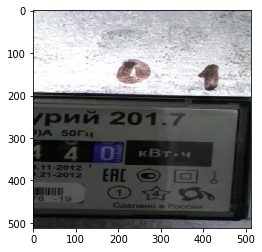

In [0]:
plt.imshow(test_data[0][2])

In [0]:
im=cv2.imread(DATA_DIR+train_df.iloc[123]['image'])

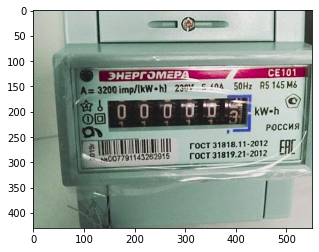

In [0]:
plt.imshow(im)

In [0]:
def pred_im(im):
  im=cv2.resize(im,(512,512))
  placeholder=np.zeros((1,512,512,3))
  placeholder[0]=im
  res=model.predict(placeholder)
  return res

In [0]:
pred_im(im)

array([[0.8567103 , 0.2807768 , 0.28361982, 0.6411461 ]], dtype=float32)

In [0]:
def resize_with_model(im,iterations=10):
  for i in tqdm(range(iterations)):
    pred_val=pred_im(im)[0]
    if(pred_val[0]>0.5):
      im=im[:,10:]
    if(pred_val[1]>0.5):
      im=im[10:,:]
    if(pred_val[2]>0.5):
      im=im[:,:-10]
    if(pred_val[0]>0.5):
      im=im[:-10,:]
  return im


In [0]:
res_im=resize_with_model(im,iterations=5)

100%|██████████| 5/5 [00:00<00:00, 47.67it/s]


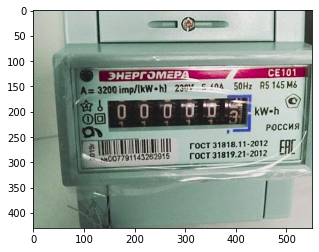

In [0]:
plt.imshow(im)

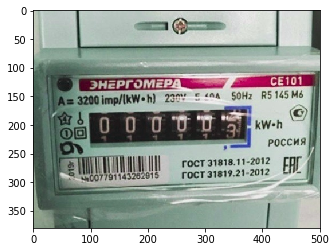

In [0]:
plt.imshow(res_im)

In [0]:
pred_im(im)

array([[0.8567103 , 0.2807768 , 0.28361982, 0.6411461 ]], dtype=float32)

In [0]:
pred_im(res_im)

array([[0.82161814, 0.29463464, 0.27986866, 0.65218234]], dtype=float32)

array([[0.8567103 , 0.2807768 , 0.28361982, 0.6411461 ]], dtype=float32)

# Data Generator Autoencoder


In [0]:
#from scipy.ndimage import imread
class DataGeneratorFull(Sequence):
    'Generates data for Keras'
    def __init__(self, df, mode='fit',
                 base_path = '../input/recursion-cellular-image-classification/train',
                 batch_size=32, dim=(640, 512), n_channels=1,size=9,
                 rotation_range=0, fill_mode='nearest',
                 vertical_flip=False, horizontal_flip=False, rescale=1/255.,
                 n_classes=5, random_state=2019, shuffle=True):
        self.dim = dim
        self.batch_size = batch_size
        self.df=df
        self.mode = mode
        self.size=size
        self.base_path = base_path
        self.rotation_range=rotation_range
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.rescale = rescale
        self.vertical_flip = vertical_flip
        self.horizontal_flip = horizontal_flip
        self.random_state = random_state
        np.random.seed(self.random_state)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int((len(self.df) / self.batch_size))

    def __getitem__(self, index):

        batch_files = self.df.iloc[index*self.batch_size:(index+1)*self.batch_size]
        
        X = self.__generate_X(batch_files)
        
        if self.mode == 'fit':
            y = X
            return X, y
        
        elif self.mode == 'predict':
            return X
        else:
            raise AttributeError('The parameter mode should be set to "fit" or "predict".')
        
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __generate_X(self, batch_files):
        buf=np.empty((self.batch_size, self.dim[0],self.dim[1],3))
        for i in range(len(batch_files)):
          if self.mode == 'fit':
            b=cv2.imread(DATA_DIR+batch_files.iloc[i]['image'])
          else:
            b=cv2.imread(batch_files[i])
          b=cv2.resize(b,(self.dim[1],self.dim[0]))
          b=b*self.rescale
          buf[i,]=b
          

        return buf


In [0]:
pretrain_df=train_df[train_df['is_serial_vertical']==False]

In [0]:
train_files, val_files = train_test_split(
    pretrain_df, test_size=0.15, random_state=2019
)

In [0]:
gen=DataGeneratorFull(train_files,dim=(256,256),batch_size=1)
val=DataGeneratorFull(val_files,dim=(256,256),batch_size=1)

CPU times: user 30.1 ms, sys: 2.89 ms, total: 33 ms
Wall time: 43.2 ms


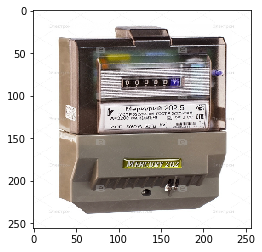

In [0]:
%%time
plt.imshow(gen[0][0][0])

# Training Autoencoder


In [0]:
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
def autoencoder(input_size = (32,32,1),descr=1,activation='sigmoid'):
    #descr=2
    inputs = Input(input_size,name='start_encoder')
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = keras.layers.Dropout(0.5)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = keras.layers.Conv2D(int(1024/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal',name='end_encoder')(conv5)
    drop5 = keras.layers.Dropout(0.5)(conv5)

    up6 = keras.layers.Conv2D(int(512/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
    #merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up6)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = keras.layers.Conv2D(int(256/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
    #merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up7)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = keras.layers.Conv2D(int(128/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
    #merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = keras.layers.Conv2D(int(64/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    #merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up9)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = keras.layers.Conv2D(3, 3, padding = 'same',activation = activation)(conv9)

    model = Model(input = inputs, output = conv10)
    
    model.summary()

    return model

In [0]:
from keras.layers import MaxPooling2D
from keras.layers import UpSampling2D
def deep_block(kernels,inputs):
  conv1_inp = keras.layers.Conv2D(kernels, (3,1), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = keras.layers.Conv2D(kernels, (1,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1_inp)
  conv1 = keras.layers.Conv2D(kernels, (3,1), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  conv1 = keras.layers.Conv2D(kernels, (1,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  conv1=keras.layers.add([conv1_inp,conv1])
  return conv1

def super_autoencoder(input_size = (32,32,1),descr=1,activation='sigmoid'):
    #descr=2
    inputs = keras.layers.Input(input_size)
    conv1 = deep_block(int(64/descr),inputs)
    pool1 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = deep_block(int(128/descr),pool1)
    pool2 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = deep_block(int(256/descr),pool2)
    pool3 = keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = deep_block(int(512/descr),pool3)
    drop4 = keras.layers.Dropout(0.5)(conv4)
    pool4 = keras.layers.MaxPooling2D(pool_size=(2, 2))(drop4)

    conv4 = deep_block(int(1024/descr),pool4)
    drop5 = keras.layers.Dropout(0.5)(conv4)

    up6 = keras.layers.Conv2D(int(512/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(drop5))
    #merge6 = keras.layers.concatenate([drop4,up6], axis = 3)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up6)
    conv6 = keras.layers.Conv2D(int(512/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = keras.layers.Conv2D(int(256/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv6))
    #merge7 = keras.layers.concatenate([conv3,up7], axis = 3)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up7)
    conv7 = keras.layers.Conv2D(int(256/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = keras.layers.Conv2D(int(128/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv7))
    #merge8 = keras.layers.concatenate([conv2,up8], axis = 3)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
    conv8 = keras.layers.Conv2D(int(128/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = keras.layers.Conv2D(int(64/descr), 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(keras.layers.UpSampling2D(size = (2,2))(conv8))
    #merge9 = keras.layers.concatenate([conv1,up9], axis = 3)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up9)
    conv9 = keras.layers.Conv2D(int(64/descr), 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)

    conv10 = keras.layers.Conv2D(3, 3, padding = 'same',activation = activation)(conv9)

    model = Model(input = inputs, output = conv10)
    
    model.summary()

    return model

In [0]:
model=autoencoder(input_size=(256,256,3),descr=8,activation='relu')

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
start_encoder (InputLayer)   (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_297 (Conv2D)          (None, 256, 256, 8)       224       
_________________________________________________________________
conv2d_298 (Conv2D)          (None, 256, 256, 8)       584       
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_299 (Conv2D)          (None, 128, 128, 16)      1168      
_________________________________________________________________
conv2d_300 (Conv2D)          (None, 128, 128, 16)      2320      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 64, 64, 16)        0  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("st..., outputs=Tensor("co...)`


In [0]:
model.compile('adam',loss='mse',metrics=['acc','mae'])

In [0]:
check=keras.callbacks.ModelCheckpoint('res_weights.h5', monitor='val_loss',save_best_only=True)

In [0]:
history = model.fit_generator(
    gen,
    validation_data=val,
    use_multiprocessing=False,
    workers=4,
    epochs=200,
    verbose=1,
    shuffle=True,
    callbacks=[check]
)

Epoch 1/200
1021/1021 [==============================] - 54s 53ms/step - loss: 0.0348 - acc: 0.3572 - mean_absolute_error: 0.1297 - val_loss: 0.0527 - val_acc: 0.3869 - val_mean_absolute_error: 0.1864
Epoch 2/200
1021/1021 [==============================] - 48s 47ms/step - loss: 0.0188 - acc: 0.3656 - mean_absolute_error: 0.1009 - val_loss: 0.0352 - val_acc: 0.4134 - val_mean_absolute_error: 0.1522
Epoch 3/200
1021/1021 [==============================] - 47s 46ms/step - loss: 0.0182 - acc: 0.3813 - mean_absolute_error: 0.0982 - val_loss: 0.0245 - val_acc: 0.4158 - val_mean_absolute_error: 0.1256
Epoch 4/200
1021/1021 [==============================] - 46s 45ms/step - loss: 0.0164 - acc: 0.3674 - mean_absolute_error: 0.0926 - val_loss: 0.0196 - val_acc: 0.4178 - val_mean_absolute_error: 0.1096
Epoch 5/200
1021/1021 [==============================] - 47s 46ms/step - loss: 0.0141 - acc: 0.3801 - mean_absolute_error: 0.0843 - val_loss: 0.0186 - val_acc: 0.3485 - val_mean_absolute_error: 0.

KeyboardInterrupt: ignored

In [0]:
def get_encoder(model):
  inp=model.inputs
  out=model.get_layer('end_encoder')
  return keras.models.Model(inputs=inp,outputs=out)

In [0]:
model.load_weights('res_weights.h5')

In [0]:
encoder_model=get_encoder(model)

ValueError: ignored

In [0]:
v=val[1]

In [0]:
res=model.predict(v[0])

In [0]:
res.shape

(1, 256, 256, 3)

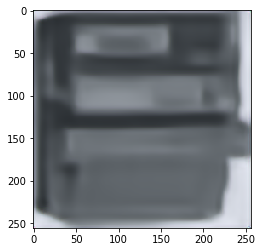

In [0]:
plt.imshow(res[0])

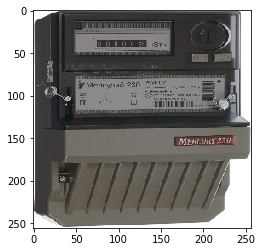

In [0]:
plt.imshow(v[0][0])

# Data Generator GAN

# Training GAN

In [0]:
class GAN():
    def __init__(self):
        self.img_rows = 64
        self.img_cols = 512
        self.channels = 3
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 1000

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)


    def build_generator(self):

        model = Sequential()

        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs,gen,val,batch_size):
        
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
          

In [0]:
model.combined.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 64, 512, 3)   0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 64, 512, 3)   0                                            
__________________________________________________________________________________________________
model_4 (Model)                 (None, 64, 512, 3)   1545425     input_6[0][0]                    
                                                                 model_3[1][0]                    
                                                                 input_5[0][0]                    
____________________________________________________________________________________________